# Data Description

- call_queueid: id
- frn_callid: call id
- frn_hcatid: hcat id
- audio_file: audio file location
- call_dt: date of call
- frn_hcat_optionid: hcat option id
- cf_frn_dnisid: tracking line number
- extension_frn_dnisid: tracking line extension routing number
- dc_dialstring: I need to check again but its a telephony term (not imp to us)
- pickup: the second at which the call was picked up
- frn_phonecodeid: a unique number to represent an agent in an account
- last_time_human_accessed:
- response_status: not sure
- duration_seconds: total call duration in seconds
- frn_review_classid_active: 
- hunch_hcat_optionid: assumed hcat_optionid
- priority_status: call priority value
- entry_path: the path on which the call came in on
- hcab_pending: disregard
- frn_lskinid: a unique value assigned to an account by which it is represented in our DB.
- cq_created: call queue record created
- path_frn_hproductid: the product on which the account is on
- time_in_queue: the time duration for which the call has been in the queue
- frn_phonecode_classid: the class of the phonecodeid
- transfer_dt: the datetime stamp when a call was transferred between queues
- ani: unique customer number
- website_call: if the call was placed via the number displayed on the website
- tz_datetime: timezone datetime

# Importing Modules

In [1]:
# !pip install -q missingno

In [2]:
%matplotlib inline

import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from scipy import stats
import matplotlib.pyplot as plt

import explorationhelp as exph

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 30)

# Defined Functions

In [4]:
def variableProfile(df, colName, varType="cat", outlierChk=True):
    df = df.copy()
    if(varType=="num"):
        print(df[colName].describe(), end="\n\n")
        
        plt.figure(figsize= (20,15))
        plt.subplot(3,1,1)
        plt.hist(df[colName], color='lightblue', edgecolor = 'black', alpha = 0.7)
        plt.xlabel(colName)
        
        plt.figure(figsize= (20,15))
        plt.subplot(3,1,2)
        sns.kdeplot(df[colName])
        plt.xlabel(colName)
        
        plt.figure(figsize= (20,15))
        plt.subplot(3,1,3)
        sns.boxplot(x= df[colName], color='lightblue')

        print(colName + " Skewness = " + str(round(stats.skew(df[colName][pd.notnull(df[colName])]), 3)), end="\n\n")

        plt.show()
        
        Q1,Q2,IQR,Lower_Whisker,Upper_Whisker = outlierIdenti(df[colName])
        upperOutCnt = sum(df[colName]>Upper_Whisker)
        lowerOutCnt = sum(df[colName]<Lower_Whisker)
        
        if(outlierChk==True):
            if((upperOutCnt>0) | (lowerOutCnt>0)):

                print(printFormat.RED +"Outliers present in " + colName + printFormat.END, end="\n\n")

                print(colName + " IQR = " + str(round(IQR,3)), end="\n\n")
                print(colName + " Lower outlier threshold = " + str(round(Lower_Whisker,3)), end="\n\n")
                print(colName + " Count of observations below lower outlier threshold = " + str(round(lowerOutCnt,3)), end="\n\n")
                print(colName + " Lower of observations below lower outlier threshold = " + str(round((lowerOutCnt/df.shape[0])*100, 2)), end="\n\n")
                print(colName + " Upper outlier threshold = " + str(round(Upper_Whisker,3)), end="\n\n")
                print(colName + " Count of observations over upper outlier threshold = " + str(round(upperOutCnt,3)), end="\n\n")
                print(colName + " Upper of observations over upper outlier threshold = " + str(round((upperOutCnt/df.shape[0])*100, 2)), end="\n\n\n\n")
                
                outlierTreatOptions(df, colName, "Quantile-based Flooring and Capping")
                outlierTreatOptions(df, colName, "median")
                outlierTreatOptions(df, colName, "mean")
            else:
                print(printFormat.GREEN + "No outliers present in " + colName + printFormat.END, end="\n\n")

        
    if(varType=="cat"):
        distTab = pd.merge(pd.DataFrame(df[colName].value_counts()).reset_index(),
         pd.DataFrame(df[colName].value_counts("normalise")*100).reset_index(),
         on="index")
        distTab.columns = [colName, "Frequency", "Percentage"]
        print(distTab, end="\n\n")
        
        plt.figure(figsize= (15,7))
        plt.subplot(1,1,1)
        plt.hist(df[colName], color='lightblue', edgecolor = 'black', alpha = 0.7)
        plt.xlabel(colName)

        plt.show()

In [5]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [6]:
def corrCust(df):
    correlation = df.corr()
    dtype_avail = []
    for i in df.dtypes:
        dtype_avail.append(i)
    
    try:
        if 'category' in dtype_avail:
            df_cat = df.select_dtypes(include=['category'])
            df_non_cat = df.select_dtypes(exclude=['category'])
            tmp_dict = {}
            for i in df_cat.columns:
                tmp_dict2 = {}
                for j in df.columns:
                     tmp_dict2[j] = cramers_v(df_cat[i], df[j])
                tmp_dict[i] = tmp_dict2
            tmp_dict = pd.DataFrame(tmp_dict)
            correlation = pd.merge(correlation, tmp_dict, left_index=True, right_index=True)
            correlation = pd.concat([correlation,tmp_dict.loc[correlation.columns].transpose()])
    except:
        print("no categorical vars")
    return correlation
    
def corrPlot(df):
    correlation = df.copy()
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(20, 20))

    cmap = sns.diverging_palette(180, 20, as_cmap=True)
    sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    plt.show()

In [7]:
class printFormat:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [8]:
def outlierIdenti(var_):
    q1=var_.quantile(0.25)
    q3=var_.quantile(0.75)
    iqr=q3-q1
    lower_whisker = q1-1.5*iqr
    upper_whisker = q3+1.5*iqr
    
    return [q1,q3,iqr,lower_whisker,upper_whisker]

def outlierTreatOptions(df, colName, treatMethodPrint=""):
    df2 = df.copy()
    df2[colName] = np.where(df2[colName] <df2[colName].quantile(0.1), df2[colName].quantile(0.1),df2[colName])
    df2[colName] = np.where(df2[colName] >df2[colName].quantile(0.9), df2[colName].quantile(0.9),df2[colName])

    print(printFormat.BOLD + "If we treat outliers with " + treatMethodPrint + printFormat.END, end="\n\n")
    
    print(df2[colName].describe(), end="\n\n")

    fig = plt.figure(figsize= (20,15))
    fig.suptitle('Treated VS Original', fontsize=16)
    plt.subplot(3,2,1)
    plt.hist(df2[colName], color='lightblue', edgecolor = 'black', alpha = 0.7)
    plt.xlabel(colName)

    plt.subplot(3,2,2)
    plt.hist(df[colName], color='lightblue', edgecolor = 'black', alpha = 0.7)
    plt.xlabel(colName)

    plt.subplot(3,2,3)
    sns.kdeplot(df2[colName])
    plt.xlabel(colName)

    plt.subplot(3,2,4)
    sns.kdeplot(df[colName])
    plt.xlabel(colName)

    plt.subplot(3,2,5)
    sns.boxplot(x= df2[colName], color='lightblue')

    plt.subplot(3,2,6)
    sns.boxplot(x= df[colName], color='lightblue')

    print(colName + " Skewness = " + str(round(stats.skew(df2[colName][pd.notnull(df2[colName])]), 3)), end="\n\n\n\n")

    plt.show()

# Importing Data

In [9]:
dat = pd.read_csv("Hcat 3 Audited 238 Data.csv")

# Data Exploration

## Metadata

### Overall View

In [10]:
dat.head()

,call_queueid,frn_callid,frn_hcatid,audio_file,call_dt,frn_hcat_optionid,cf_frn_dnisid,extension_frn_dnisid,dc_dialstring,pickup,frn_phonecodeid,last_time_human_accessed,response_status,duration_seconds,frn_review_classid_active,hunch_hcat_optionid,priority_status,entry_path,hcab_pending,frn_lskinid,cq_created,path_frn_hproductid,time_in_queue,frn_phonecode_classid,transfer_dt,ani,website_call,tz_datetime
0,1784285815,6000070185177,3,https://s3.amazonaws.com/cic-audio/5105/202012...,2020-12-21 14:00:20 +0000,127601,34917289,NaN,7139413600.00000,0.00000,NaN,2020-12-22 13:01:27 +0000,10.00000,217,1.00000,NaN,1,1.00000,0.00000,116892,2020-12-22 13:01:27 +0000,12.00000,2.00000,NaN,NaN,3462412554.00000,0,2020-12-21 14:00:20 +0000
1,1789345059,6000073774587,3,https://s3.amazonaws.com/cic-audio/5108/202012...,2020-12-28 10:52:09 +0000,987654,3764241,35901302.00000,6784931059.00000,19.00000,NaN,2020-12-30 07:00:27 +0000,10.00000,386,NaN,NaN,1,5.00000,0.00000,72160,2020-12-30 07:00:27 +0000,3.00000,120.00000,NaN,NaN,NaN,0,NaN
2,1796464622,6000079355690,3,https://s3.amazonaws.com/cic-audio/5102/202101...,2021-01-05 10:14:00 +0000,127599,34912558,NaN,NaN,NaN,NaN,2021-01-08 18:01:22 +0000,10.00000,77,NaN,NaN,1,6.00000,0.00000,91840,2021-01-08 18:01:22 +0000,3.00000,3.00000,NaN,NaN,NaN,0,NaN
3,1797102296,6000080171268,3,https://s3.amazonaws.com/cic-audio/5107/202101...,2021-01-06 09:59:07 +0000,127605,34996631,35605735.00000,8474736071.00000,NaN,NaN,2021-01-09 15:27:43 +0000,10.00000,169,NaN,NaN,1,6.00000,0.00000,117997,2021-01-09 15:27:43 +0000,12.00000,0.00000,NaN,NaN,NaN,0,NaN
4,1797276202,6000083220618,3,https://s3.amazonaws.com/cic-audio/5107/202101...,2021-01-09 19:19:13 +0000,127601,3341077,3819732.00000,5035974632.00000,18.00000,NaN,2021-01-09 20:59:26 +0000,10.00000,172,1.00000,NaN,1,1.00000,0.00000,54913,2021-01-09 20:59:26 +0000,12.00000,2.00000,NaN,NaN,9712947766.00000,0,2021-01-09 17:19:13 +0000


In [11]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   call_queueid               17197 non-null  int64  
 1   frn_callid                 17197 non-null  int64  
 2   frn_hcatid                 17197 non-null  int64  
 3   audio_file                 17197 non-null  object 
 4   call_dt                    17197 non-null  object 
 5   frn_hcat_optionid          17197 non-null  int64  
 6   cf_frn_dnisid              17197 non-null  int64  
 7   extension_frn_dnisid       8979 non-null   float64
 8   dc_dialstring              16601 non-null  float64
 9   pickup                     16432 non-null  float64
 10  frn_phonecodeid            5278 non-null   float64
 11  last_time_human_accessed   17160 non-null  object 
 12  response_status            17189 non-null  float64
 13  duration_seconds           17197 non-null  int

In [12]:
dat.describe()

,call_queueid,frn_callid,frn_hcatid,frn_hcat_optionid,cf_frn_dnisid,extension_frn_dnisid,dc_dialstring,pickup,frn_phonecodeid,response_status,duration_seconds,frn_review_classid_active,hunch_hcat_optionid,priority_status,entry_path,hcab_pending,frn_lskinid,path_frn_hproductid,time_in_queue,frn_phonecode_classid,transfer_dt,ani,website_call
count,17197.00000,17197.00000,17197.00000,17197.00000,17197.00000,8979.00000,16601.00000,16432.00000,5278.00000,17189.00000,17197.00000,1024.00000,0.00000,17197.00000,17168.00000,17159.00000,17197.00000,17161.00000,17160.00000,0.00000,0.00000,2353.00000,17197.00000
mean,2150104164.60877,9680236972225.50977,3.00000,848821.73030,22457691.39920,27172263.63103,6109243115.56936,18.26430,3729249.43710,10.00000,308.81253,1.85645,NaN,0.93574,5.26200,0.00000,77395.59278,6.89966,1020.94318,NaN,NaN,6322829958.55971,0.00896
std,38566879.00973,34451085194464.41406,0.00000,316439.73251,16097986.66765,14241048.45122,2422806930.01329,15.34653,1398081.35101,0.00000,271.81448,1.39819,NaN,0.24521,1.13311,0.00000,53083.70883,4.86522,2624.99640,NaN,NaN,10475059679.40758,0.09421
min,1670559450.00000,6000070185177.00000,3.00000,127599.00000,2389.00000,225306.00000,2012541550.00000,0.00000,10400.00000,10.00000,8.00000,0.00000,NaN,0.00000,0.00000,0.00000,11.00000,1.00000,0.00000,NaN,NaN,266696687.00000,0.00000
25%,2153801211.00000,6000405536833.00000,3.00000,987654.00000,3509090.00000,4343947.00000,4065424963.00000,7.00000,3970682.75000,10.00000,124.00000,1.00000,NaN,1.00000,5.00000,0.00000,23047.00000,2.00000,593.00000,NaN,NaN,4074517115.00000,0.00000
50%,2155355566.00000,6000406858752.00000,3.00000,987654.00000,34947392.00000,35505141.00000,6197275901.00000,16.00000,4299042.00000,10.00000,229.00000,2.00000,NaN,1.00000,5.00000,0.00000,75843.00000,4.00000,865.00000,NaN,NaN,6158603781.00000,0.00000
75%,2156729327.00000,6000407837865.00000,3.00000,987654.00000,36290413.00000,36375443.00000,8175291103.00000,25.00000,4485984.25000,10.00000,414.00000,2.00000,NaN,1.00000,5.00000,0.00000,138008.00000,12.00000,1339.00000,NaN,NaN,8172989679.00000,0.00000
max,2158103364.00000,332203100002161.00000,3.00000,987654.00000,36688567.00000,36688311.00000,9896844877.00000,192.00000,4663638.00000,10.00000,7200.00000,14.00000,NaN,1.00000,8.00000,0.00000,149933.00000,20.00000,263423.00000,NaN,NaN,491729906340.00000,1.00000


Variable with all missing values can be dropped:
- hunch_hcat_optionid
- frn_phonecode_classid
- transfer_dt

Variable with all constant values can be dropped:
- frn_hcatid
- response_status
- hcab_pending

Date variable datatype can be changed to datetime:
- call_dt
- last_time_human_accessed
- cq_created
- tz_datetime

Float variables can be converted into int after handling NAN's

In [13]:
# Droping variables
dat.drop(['hunch_hcat_optionid',
          'frn_phonecode_classid',
          'transfer_dt',
          'frn_hcatid',
          'response_status',
          'hcab_pending'], axis=1, inplace=True)

In [14]:
# Changing data-type
dat['call_dt'] = pd.to_datetime(dat['call_dt'])
dat['last_time_human_accessed'] = pd.to_datetime(dat['last_time_human_accessed'])
dat['cq_created'] = pd.to_datetime(dat['cq_created'])
dat['tz_datetime'] = pd.to_datetime(dat['tz_datetime'])

In [15]:
dat['call_queueid'] = dat['call_queueid'].astype(str)
dat['frn_callid'] = dat['frn_callid'].astype(str)
dat['frn_hcat_optionid'] = dat['frn_hcat_optionid'].astype(str)

### Missing Values

<AxesSubplot:>

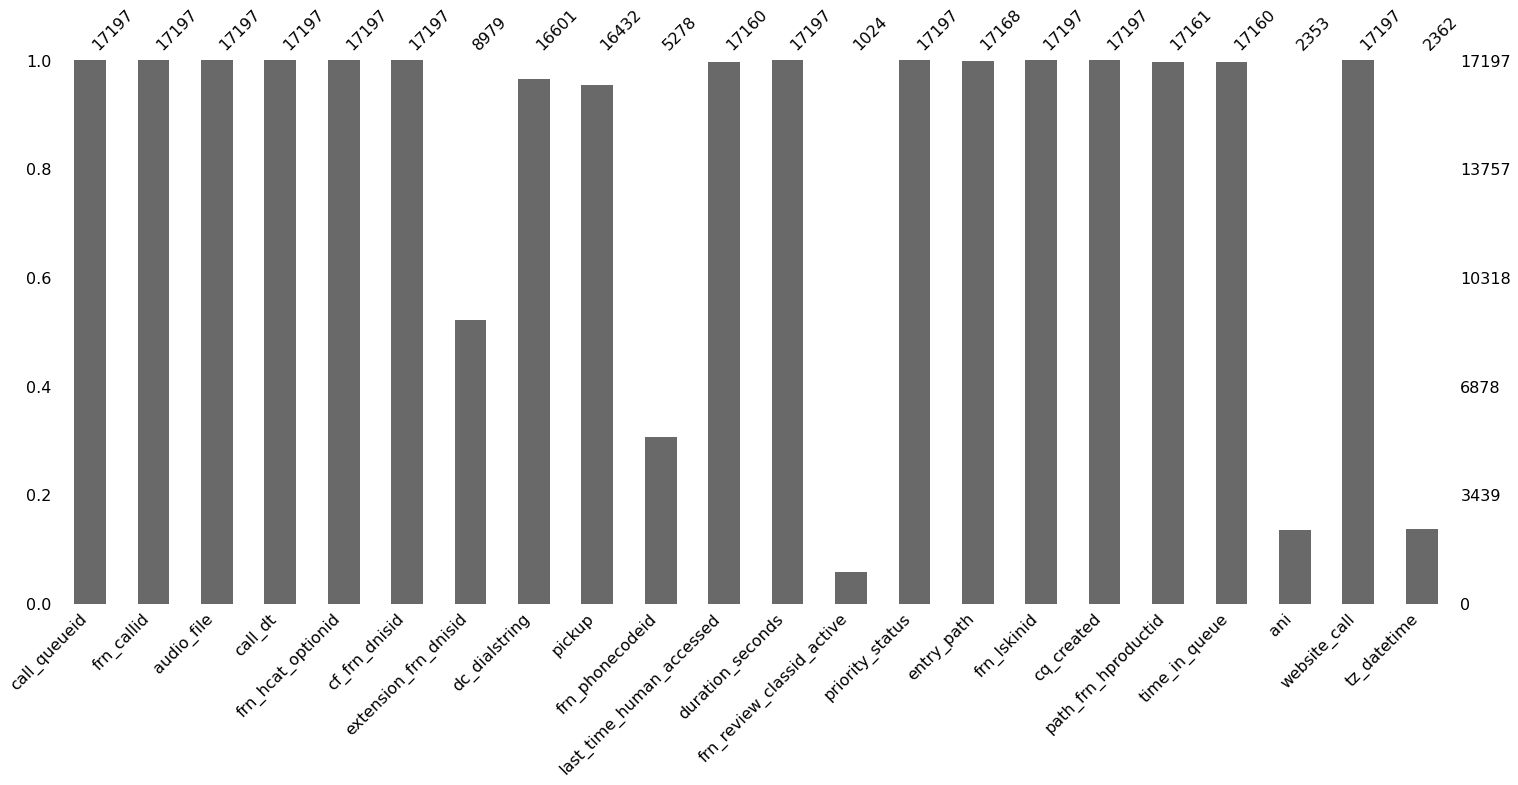

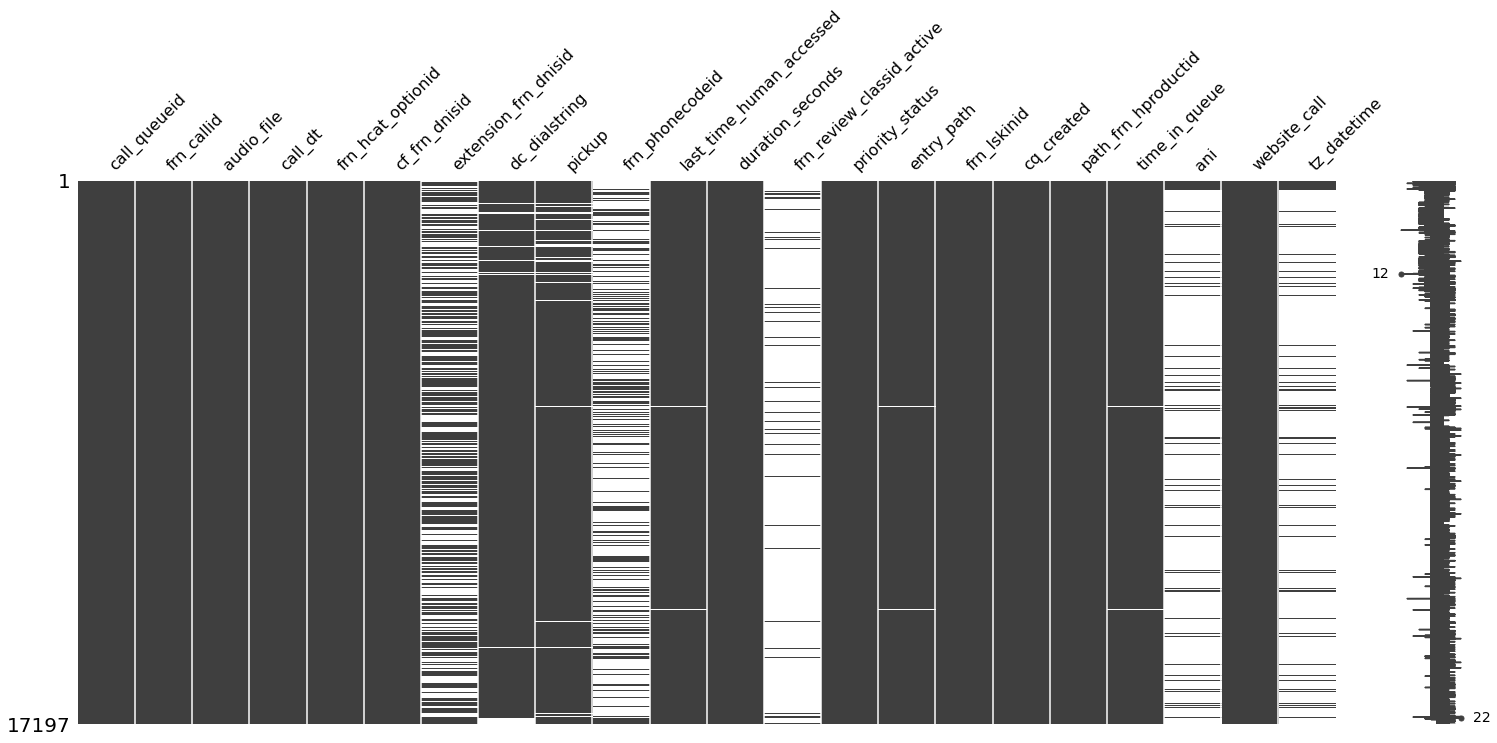

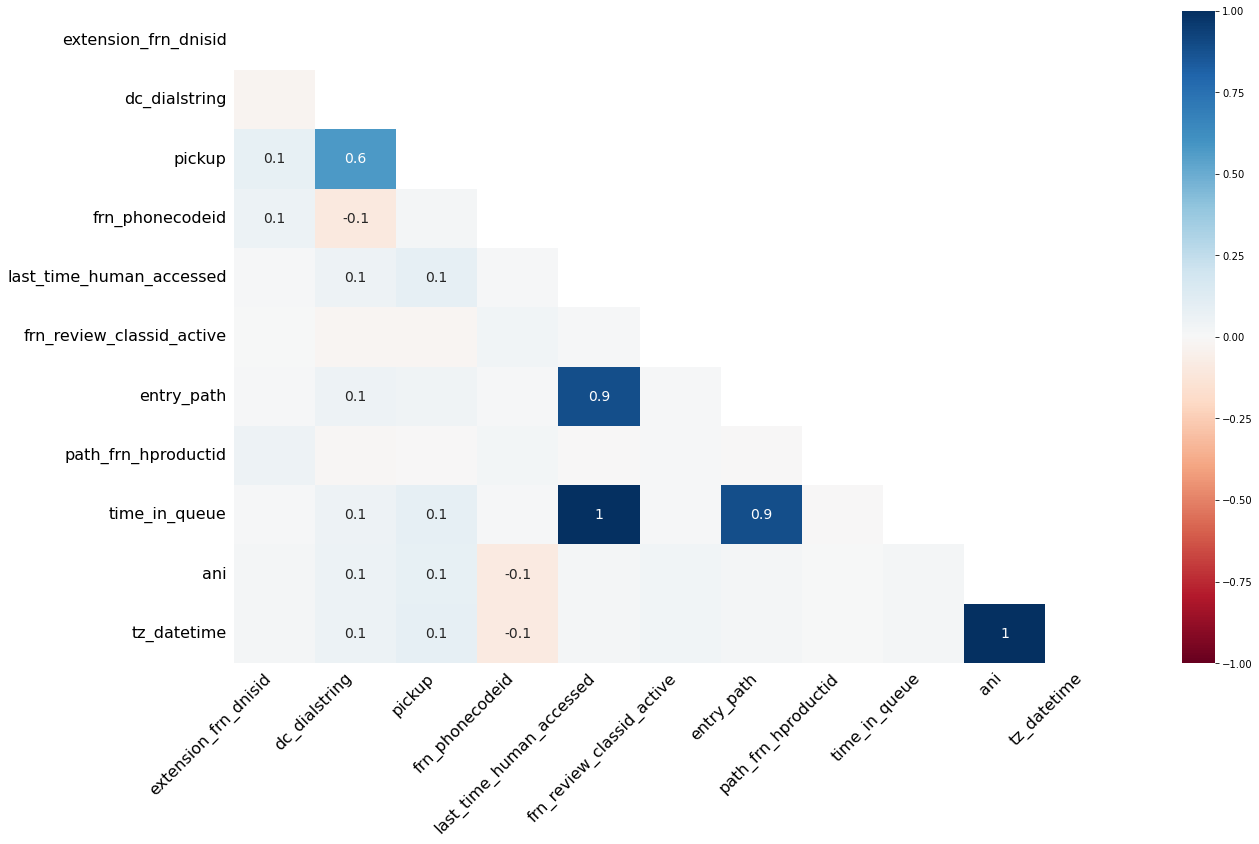

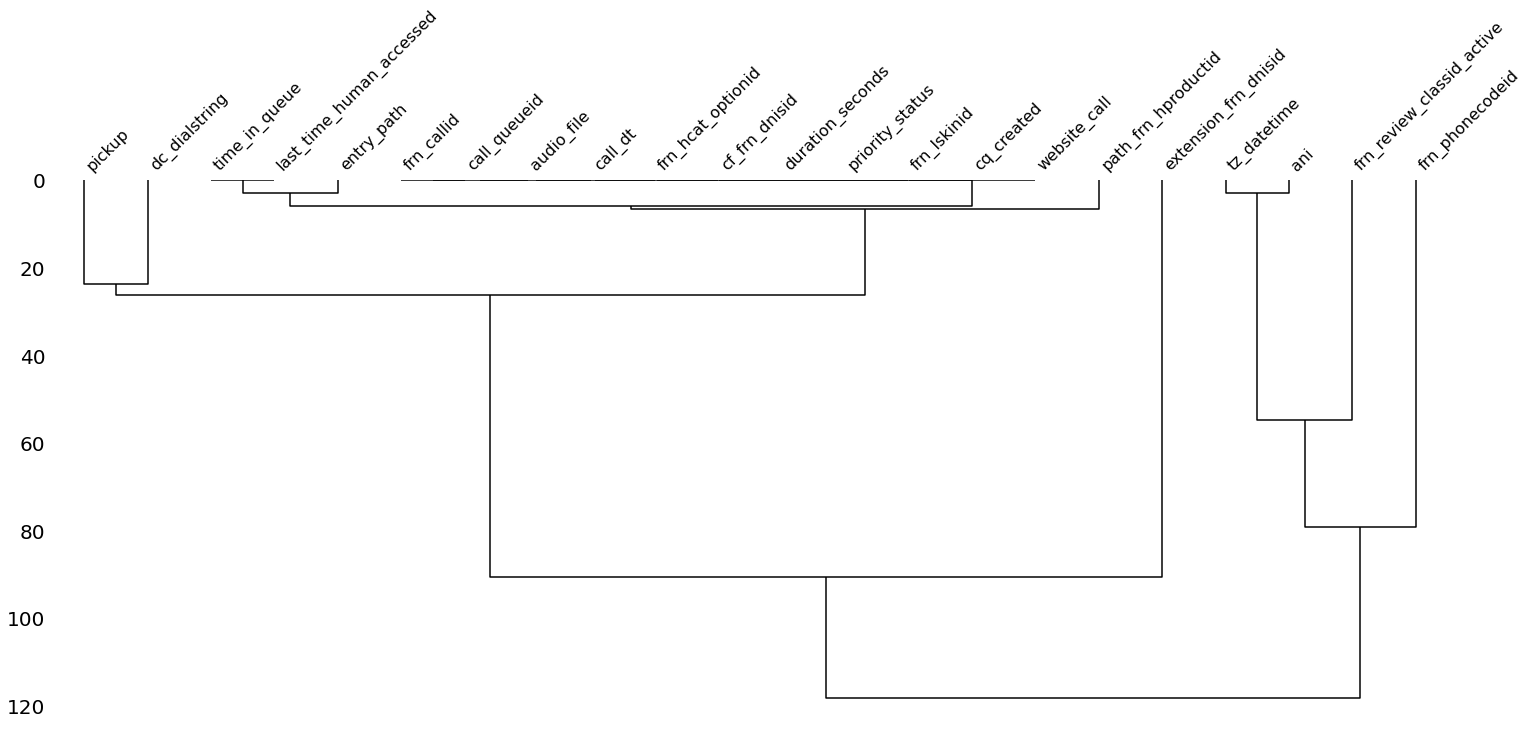

In [16]:
msno.bar(dat)
msno.matrix(dat)
msno.heatmap(dat)
msno.dendrogram(dat)

### Variable Profiling

#### call_dt

In [17]:
clN = 'call_dt'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN+'_year'] = dat_tmp[clN].dt.year
dat_tmp[clN+'_month'] = dat_tmp[clN].dt.month
dat_tmp[clN+'_day'] = dat_tmp[clN].dt.day
dat_tmp[clN+'_day_of_week'] = dat_tmp[clN].dt.day_of_week
dat_tmp[clN+'_hour'] = dat_tmp[clN].dt.hour
dat_tmp[clN+'_year_month'] = dat_tmp[clN+'_year'].astype(str)+' : '+dat_tmp[clN+'_month'].astype(str)

,call_dt,Frequency,Percentage
0,False,17197,100.00000


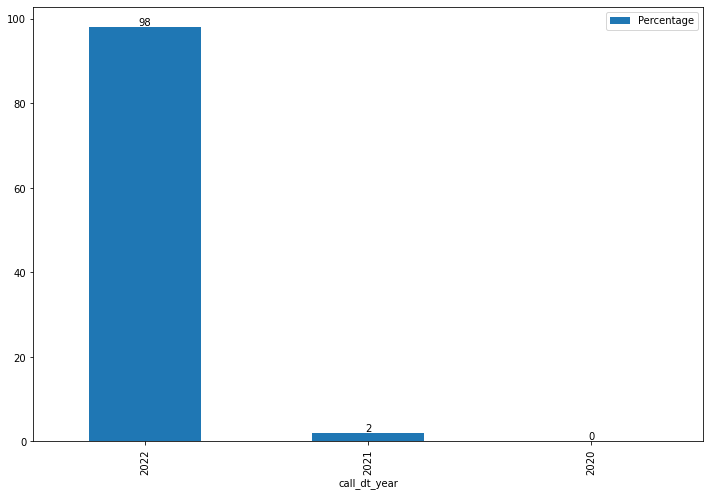

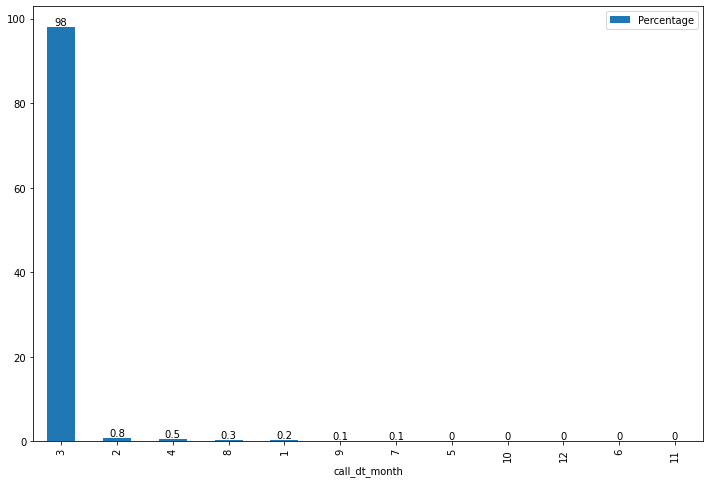

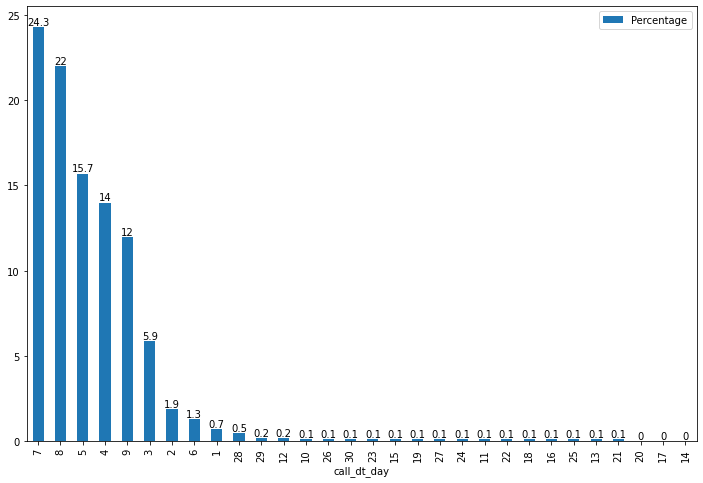

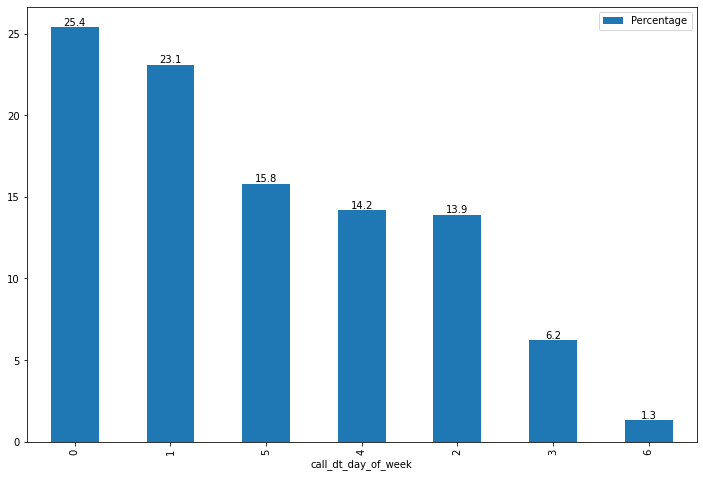

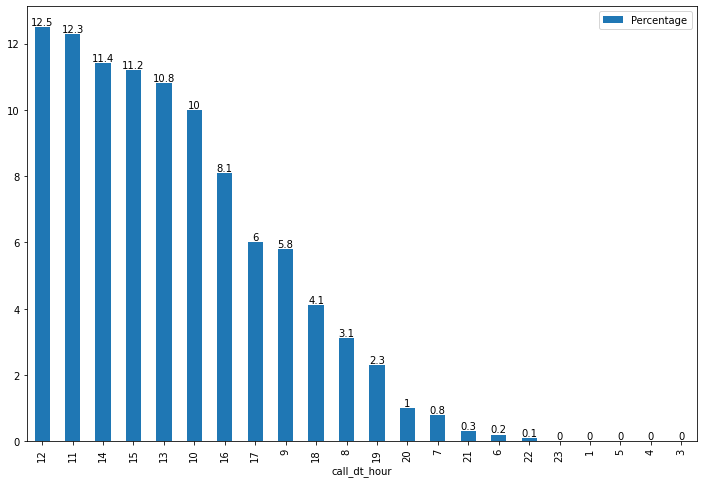

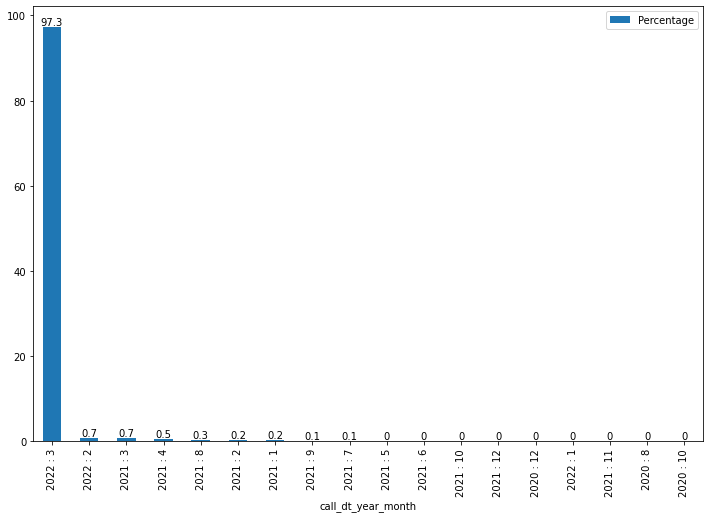

In [18]:
for cln in dat_tmp.columns:
    if clN+"_" in cln:
        ax = exph.distTab(dat_tmp, cln).plot.bar(x=cln,y='Percentage', figsize=(12, 8))
        ax.bar_label(ax.containers[0])

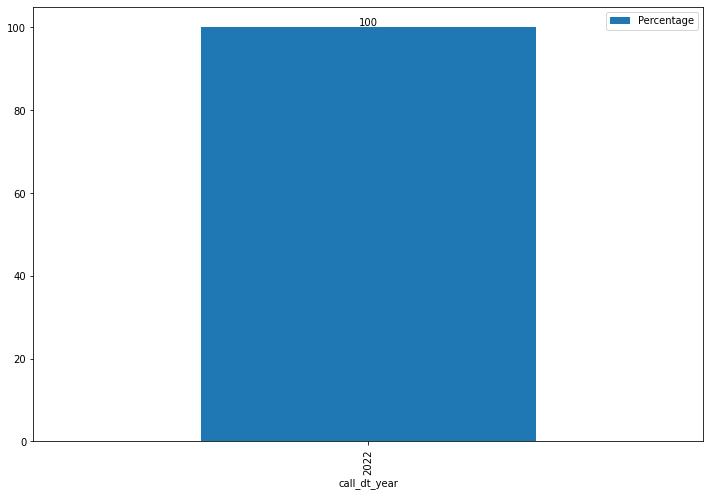

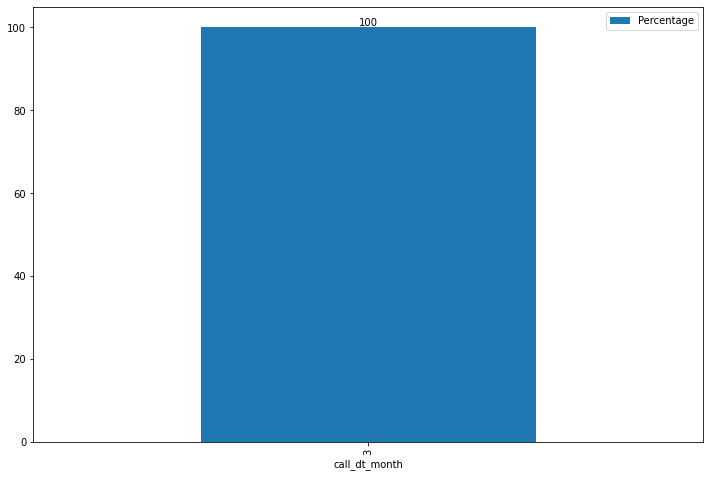

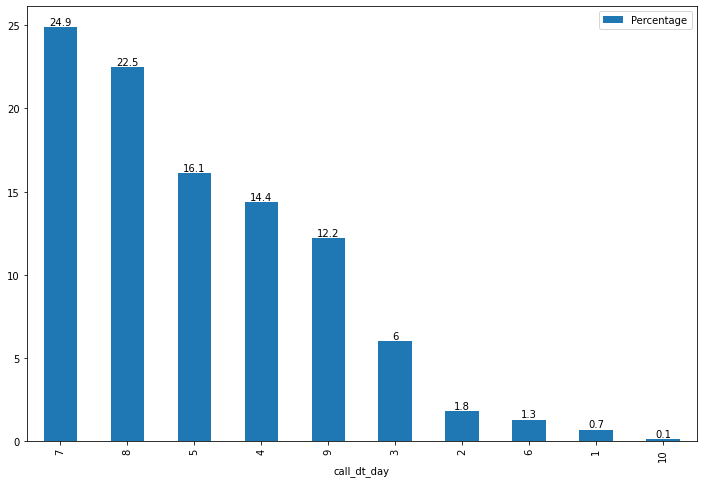

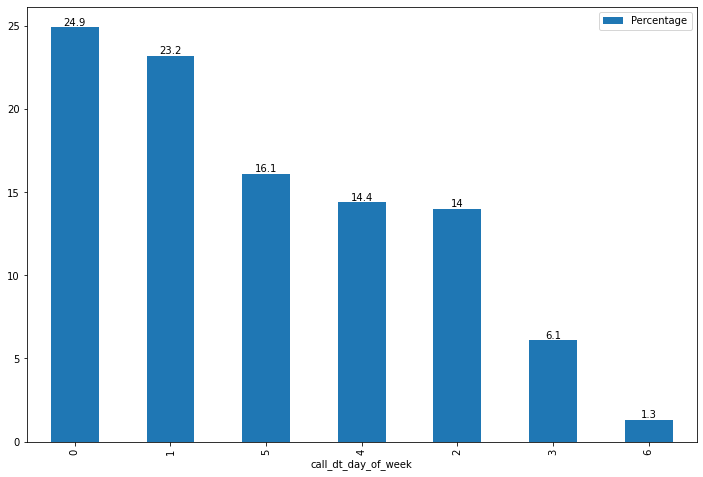

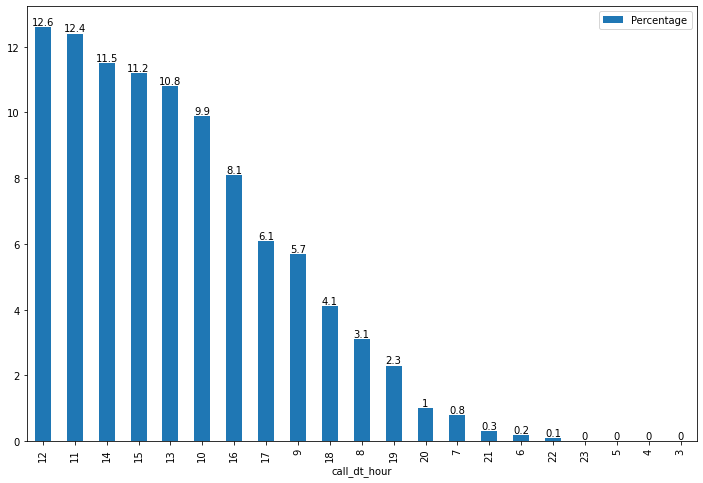

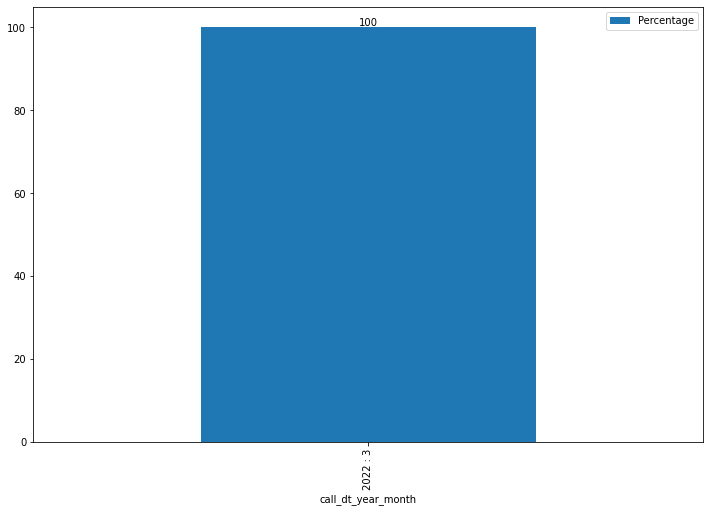

In [19]:
# For understanding the distributions for 97% of our data
dat_tmp = dat_tmp[dat_tmp['call_dt_year_month']=='2022 : 3'].copy()
for cln in dat_tmp.columns:
    if clN+"_" in cln:
        ax = exph.distTab(dat_tmp, cln).plot.bar(x=cln,y='Percentage', figsize=(12, 8))
        ax.bar_label(ax.containers[0])

Observations
- 97% data is from March 2022
- There is sampling bias

#### frn_hcat_optionid

,frn_hcat_optionid,Frequency,Percentage
0,False,17197,100.00000


,frn_hcat_optionid,Frequency,Percentage
0,987654,14421,83.90000
1,127605,1482,8.60000
2,127606,588,3.40000
3,127600,305,1.80000
4,127599,203,1.20000
5,127604,95,0.60000
6,127603,72,0.40000
7,127601,31,0.20000


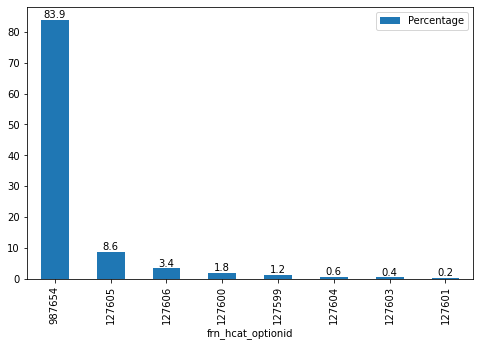

In [20]:
clN = 'frn_hcat_optionid'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
ax = exph.distTab(dat, clN).plot.bar(x=clN,y='Percentage', figsize=(8, 5))
ax.bar_label(ax.containers[0])
exph.distTab(dat, clN)

Observation:
- ~84% calls were handled
- Highly imbalanced

#### cf_frn_dnisid

In [21]:
clN = 'cf_frn_dnisid'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
exph.distTab(dat, clN)

,cf_frn_dnisid,Frequency,Percentage
0,False,17197,100.00000


,cf_frn_dnisid,Frequency,Percentage
0,35921707,62,0.40000
1,2513947,42,0.20000
2,35134637,41,0.20000
3,35897447,39,0.20000
4,34585754,32,0.20000
...,...,...,...
6910,34941375,1,0.00000
6911,2453441,1,0.00000
6912,36532634,1,0.00000
6913,2094080,1,0.00000


Observation:
- ID variable with very-high cardinality

#### extension_frn_dnisid

In [22]:
clN = 'extension_frn_dnisid'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,extension_frn_dnisid,Frequency,Percentage
0,False,8979,52.20000
1,True,8218,47.80000


,extension_frn_dnisid,Frequency,Percentage
0,35989293,48,0.50000
1,36677702,39,0.40000
2,36368637,31,0.30000
3,34910679,30,0.30000
4,36442594,28,0.30000
...,...,...,...
2468,34979842,1,0.00000
2469,3763227,1,0.00000
2470,4036333,1,0.00000
2471,3884618,1,0.00000


Observation:
- ID variable with very-high cardinality
- ~49% data is missing

#### dc_dialstring

In [23]:
clN = 'dc_dialstring'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,dc_dialstring,Frequency,Percentage
0,False,16601,96.50000
1,True,596,3.50000


,dc_dialstring,Frequency,Percentage
0,-2147483648,15629,94.10000
1,2053243371,30,0.20000
2,2106355000,29,0.20000
3,2132047065,24,0.10000
4,2103571410,21,0.10000
...,...,...,...
257,2086956260,1,0.00000
258,2126861653,1,0.00000
259,2145472949,1,0.00000
260,2108339659,1,0.00000


Observation:
- 94% of the values are one value
- Discrete variable with high cardinality

#### pickup

,pickup,Frequency,Percentage
0,False,16432,95.60000
1,True,765,4.40000


count   16432.00000
mean       18.26430
std        15.34653
min         0.00000
25%         7.00000
50%        16.00000
75%        25.00000
max       192.00000
Name: pickup, dtype: float64

pickup Skewness = 1.783



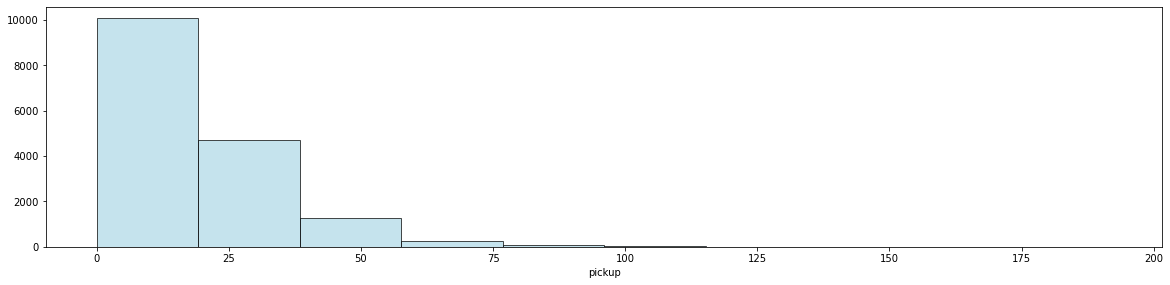

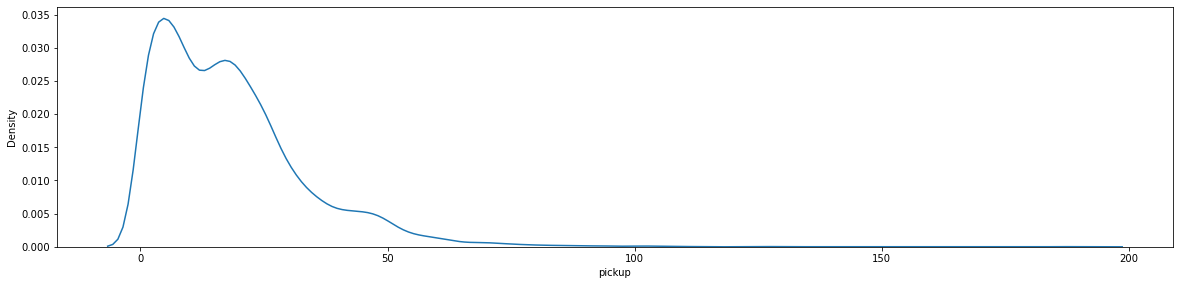

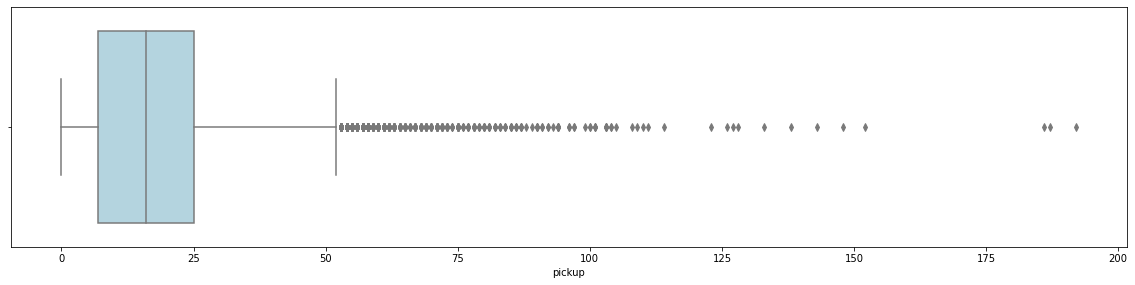

Outliers present in pickup

pickup IQR = 18.0

pickup Lower outlier threshold = -20.0

pickup Count of observations below lower outlier threshold = 0

pickup Lower of observations below lower outlier threshold = 0.0

pickup Upper outlier threshold = 52.0

pickup Count of observations over upper outlier threshold = 507

pickup Upper of observations over upper outlier threshold = 3.09



If we treat outliers with Quantile-based Flooring and Capping

count   16432.00000
mean       17.09049
std        11.46054
min         3.00000
25%         7.00000
50%        16.00000
75%        25.00000
max        38.00000
Name: pickup, dtype: float64

pickup Skewness = 0.466





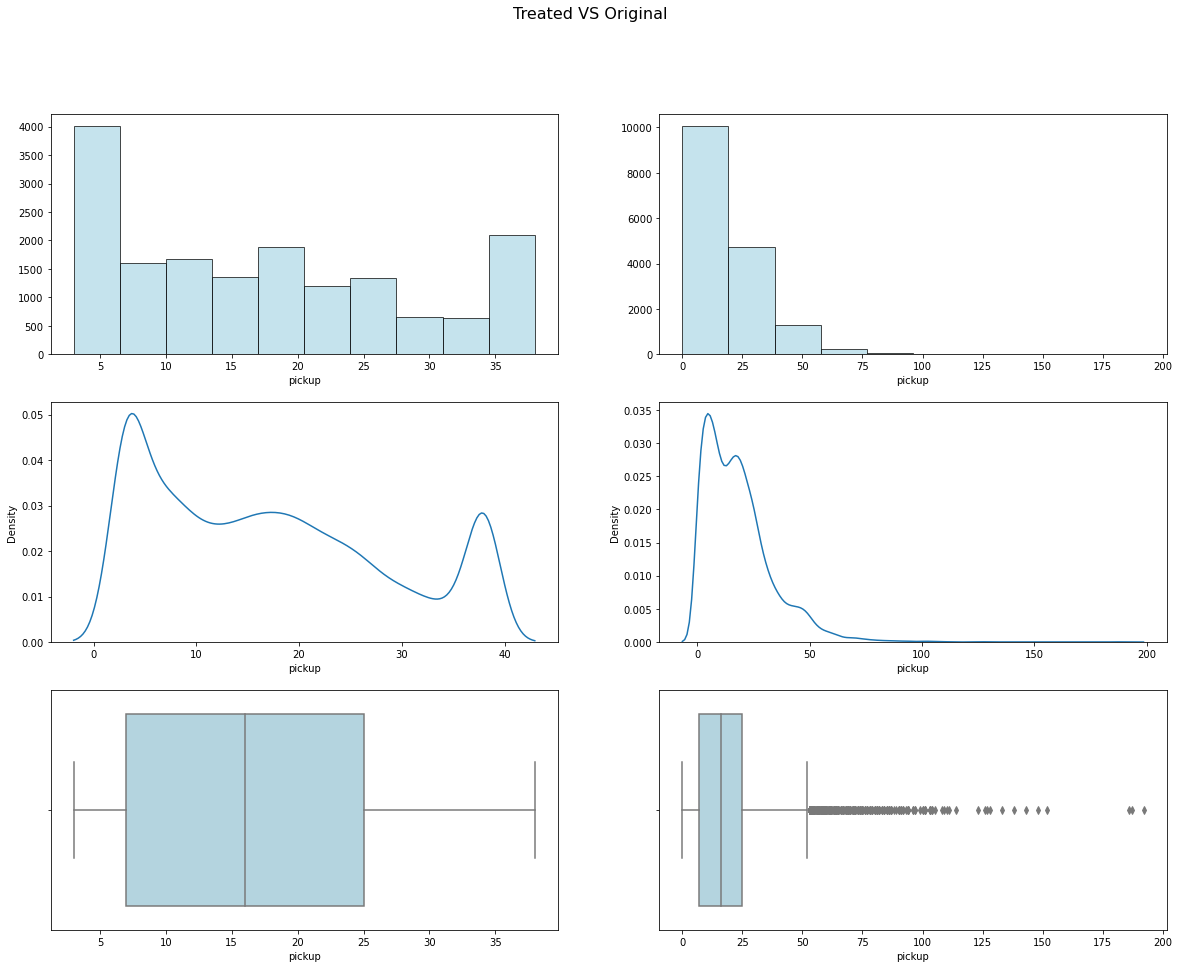

If we treat outliers with median

count   16432.00000
mean       17.09049
std        11.46054
min         3.00000
25%         7.00000
50%        16.00000
75%        25.00000
max        38.00000
Name: pickup, dtype: float64

pickup Skewness = 0.466





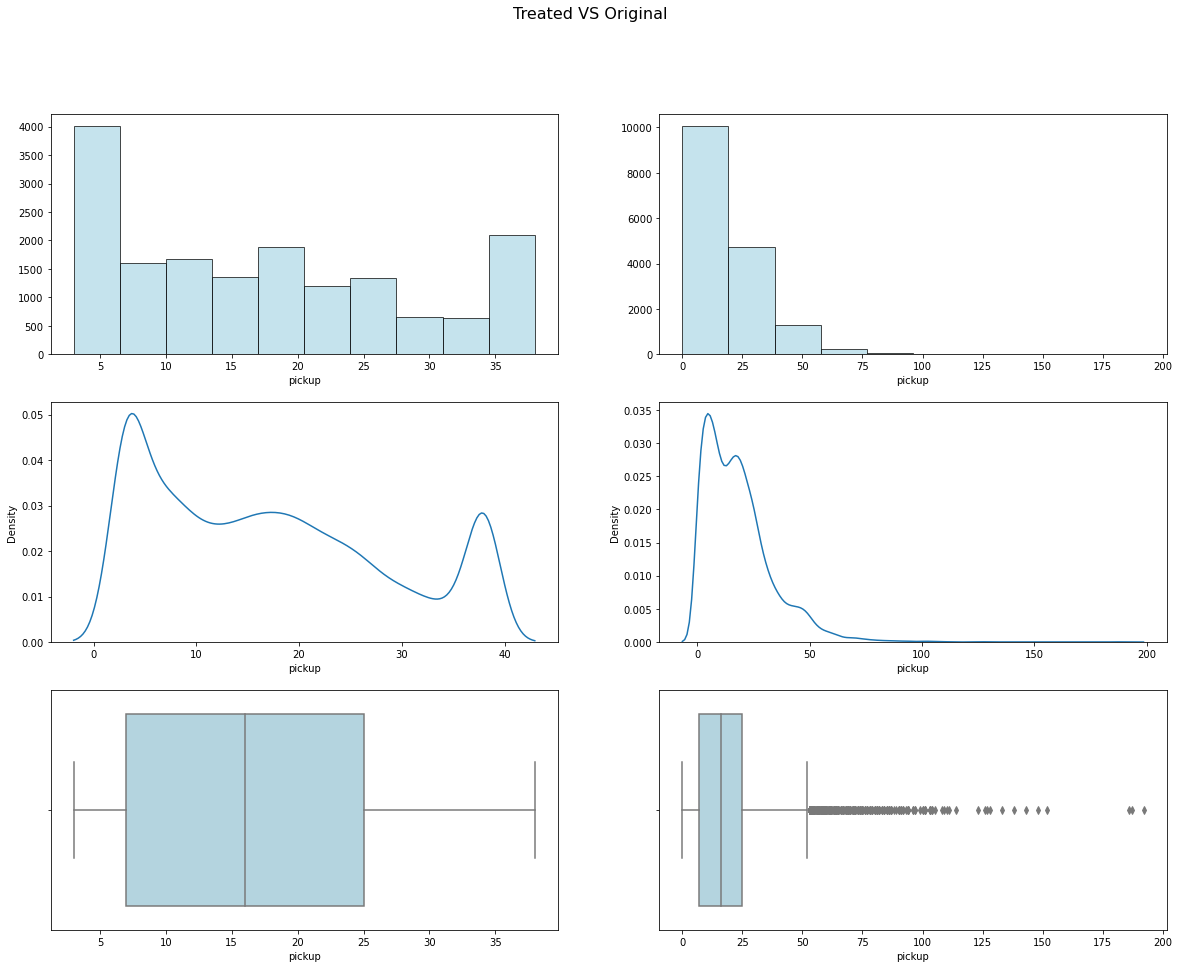

If we treat outliers with mean

count   16432.00000
mean       17.09049
std        11.46054
min         3.00000
25%         7.00000
50%        16.00000
75%        25.00000
max        38.00000
Name: pickup, dtype: float64

pickup Skewness = 0.466





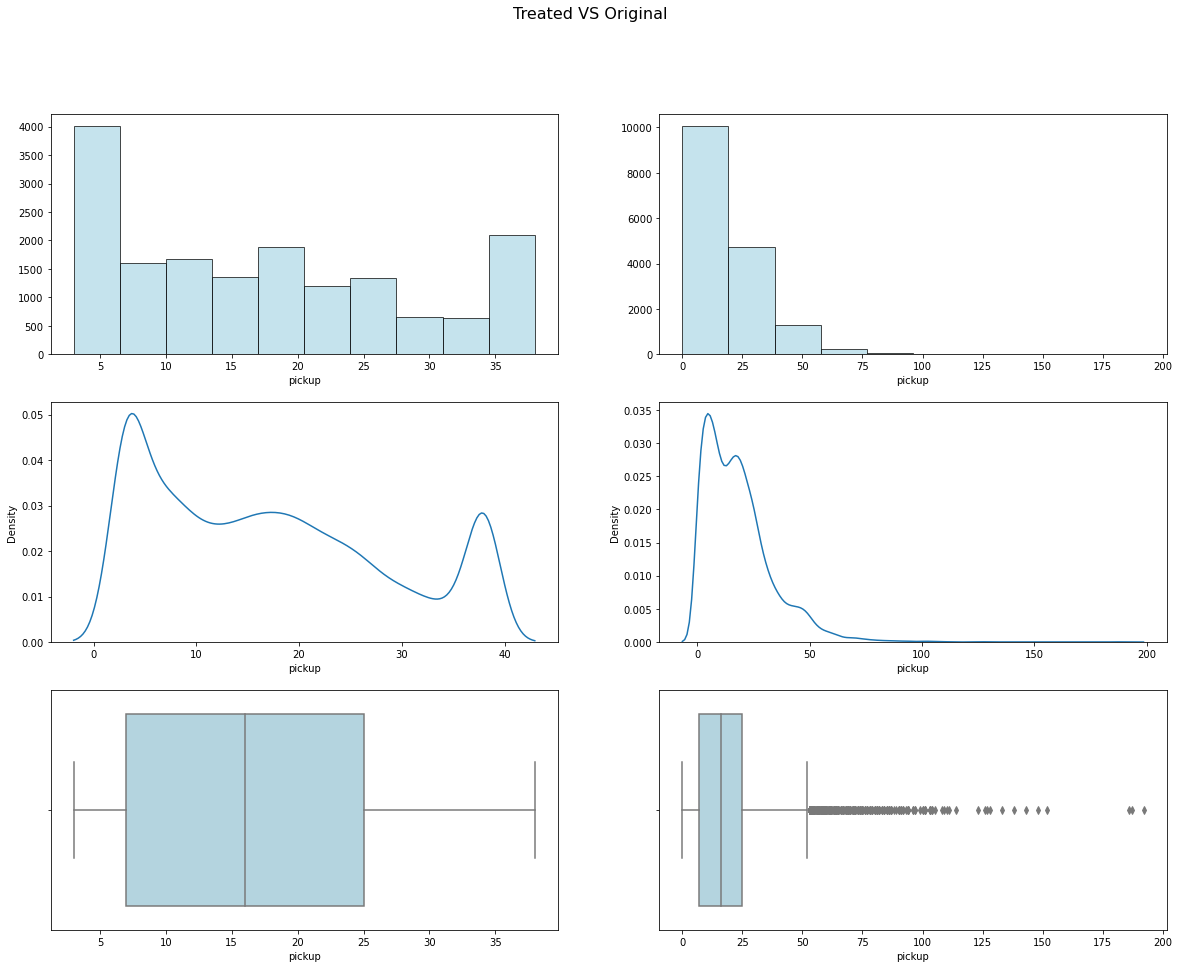

In [24]:
clN = 'pickup'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
variableProfile(dat_tmp, colName=clN, varType='num')

Observation:
- Over 60% calls are answered under 20 seconds
- Distribution in positively skewed
- Outliers are present

#### frn_phonecodeid

In [25]:
clN = 'frn_phonecodeid'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,frn_phonecodeid,Frequency,Percentage
0,True,11919,69.30000
1,False,5278,30.70000


,frn_phonecodeid,Frequency,Percentage
0,623626,15,0.30000
1,4436872,9,0.20000
2,3756847,9,0.20000
3,3757725,8,0.20000
4,4570276,7,0.10000
...,...,...,...
3918,3725367,1,0.00000
3919,3916645,1,0.00000
3920,4153606,1,0.00000
3921,4626709,1,0.00000


Observation:
- ID variable with very-high cardinality
- ~31% data is missing

#### last_time_human_accessed

In [26]:
clN = 'last_time_human_accessed'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN+'_year'] = dat_tmp[clN].dt.year
dat_tmp[clN+'_month'] = dat_tmp[clN].dt.month
dat_tmp[clN+'_day'] = dat_tmp[clN].dt.day
dat_tmp[clN+'_day_of_week'] = dat_tmp[clN].dt.day_of_week
dat_tmp[clN+'_hour'] = dat_tmp[clN].dt.hour
dat_tmp[clN+'_year_month'] = dat_tmp[clN+'_year'].astype(str)+' : '+dat_tmp[clN+'_month'].astype(str)

,last_time_human_accessed,Frequency,Percentage
0,False,17160,99.80000
1,True,37,0.20000


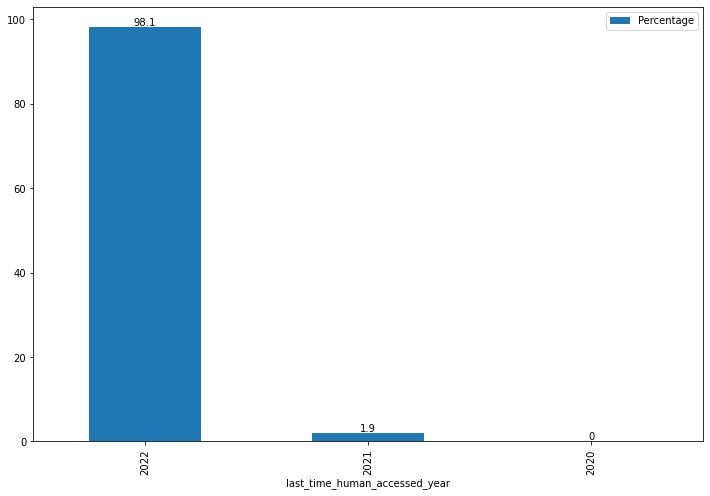

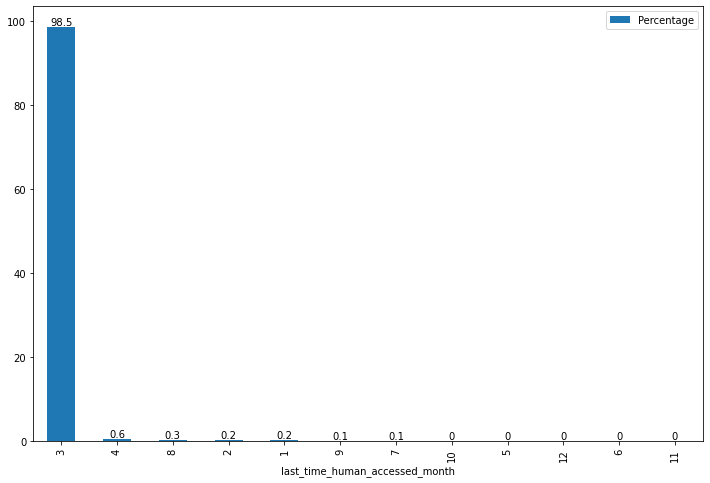

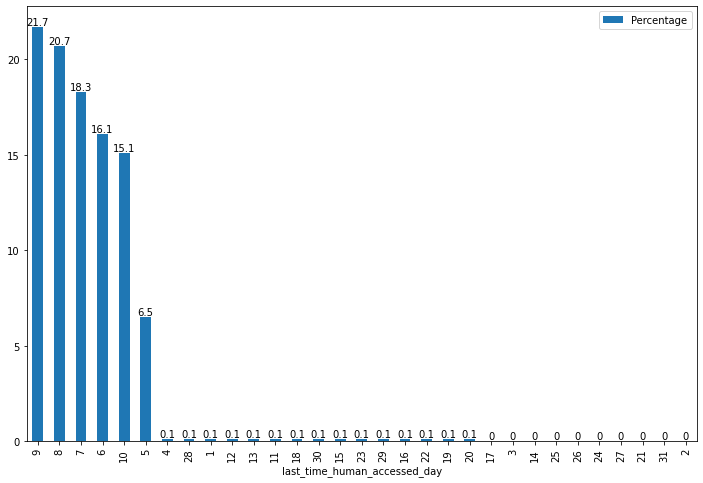

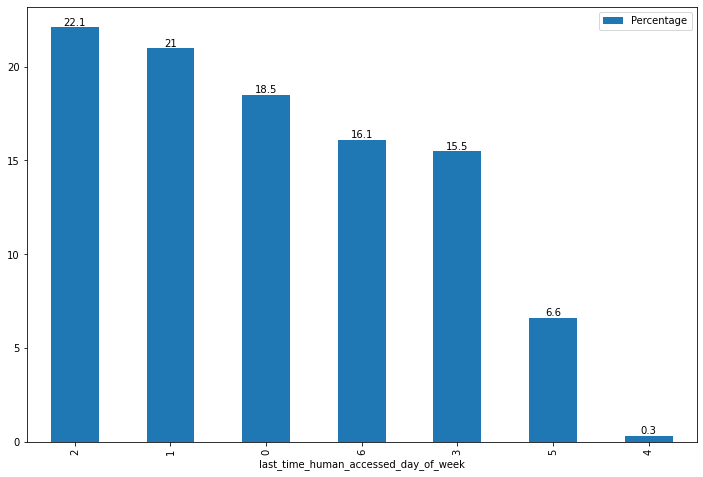

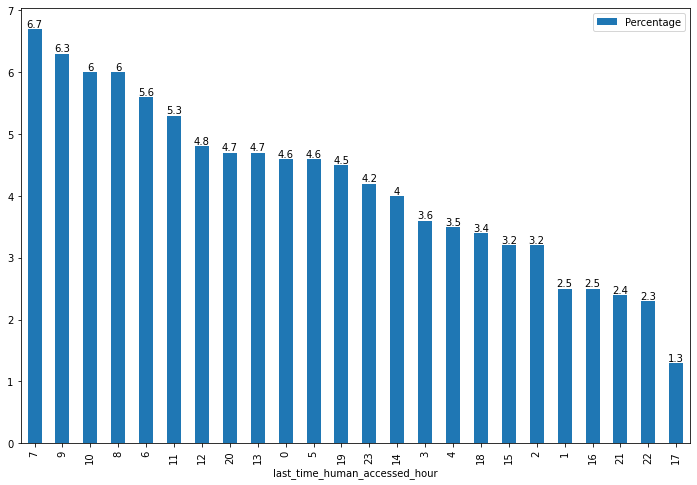

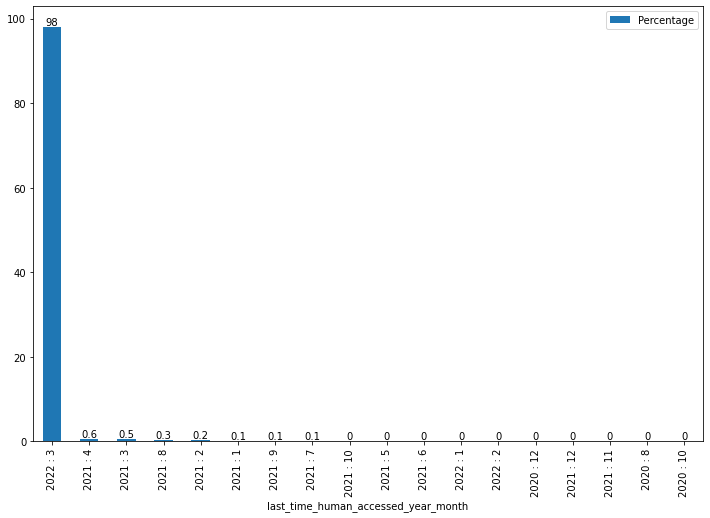

In [27]:
for cln in dat_tmp.columns:
    if clN+"_" in cln:
        ax = exph.distTab(dat_tmp, cln).plot.bar(x=cln,y='Percentage', figsize=(12, 8))
        ax.bar_label(ax.containers[0])

Observations
- 98% data is from March 2022
- There is sampling bias

#### duration_seconds

,duration_seconds,Frequency,Percentage
0,False,17197,100.00000


count   17197.00000
mean      308.81253
std       271.81448
min         8.00000
25%       124.00000
50%       229.00000
75%       414.00000
max      7200.00000
Name: duration_seconds, dtype: float64

duration_seconds Skewness = 3.395



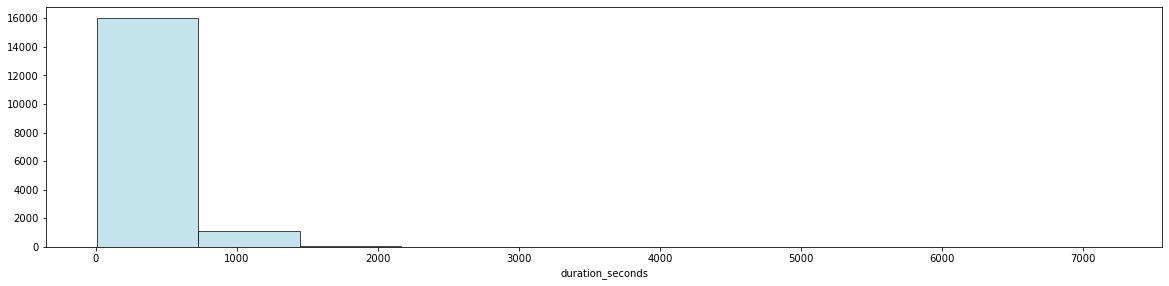

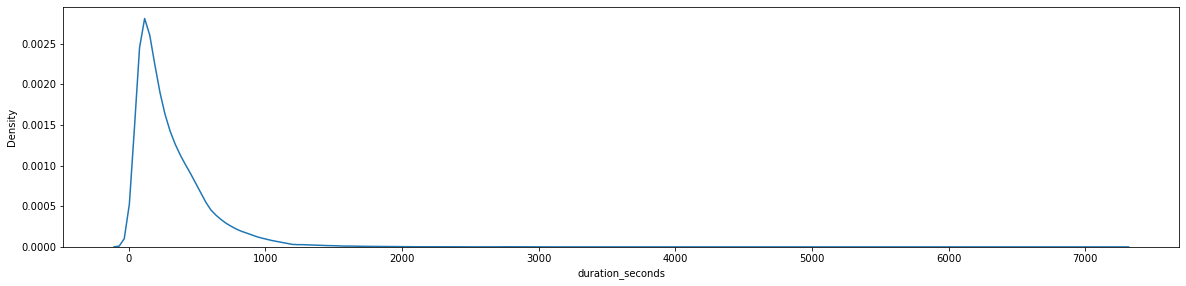

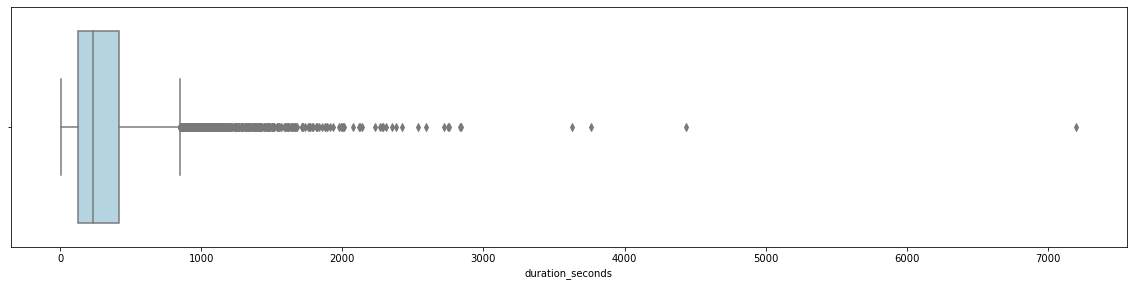

Outliers present in duration_seconds

duration_seconds IQR = 290.0

duration_seconds Lower outlier threshold = -311.0

duration_seconds Count of observations below lower outlier threshold = 0

duration_seconds Lower of observations below lower outlier threshold = 0.0

duration_seconds Upper outlier threshold = 849.0

duration_seconds Count of observations over upper outlier threshold = 751

duration_seconds Upper of observations over upper outlier threshold = 4.37



If we treat outliers with Quantile-based Flooring and Capping

count   17197.00000
mean      283.41554
std       184.63025
min        77.00000
25%       124.00000
50%       229.00000
75%       414.00000
max       637.00000
Name: duration_seconds, dtype: float64

duration_seconds Skewness = 0.685





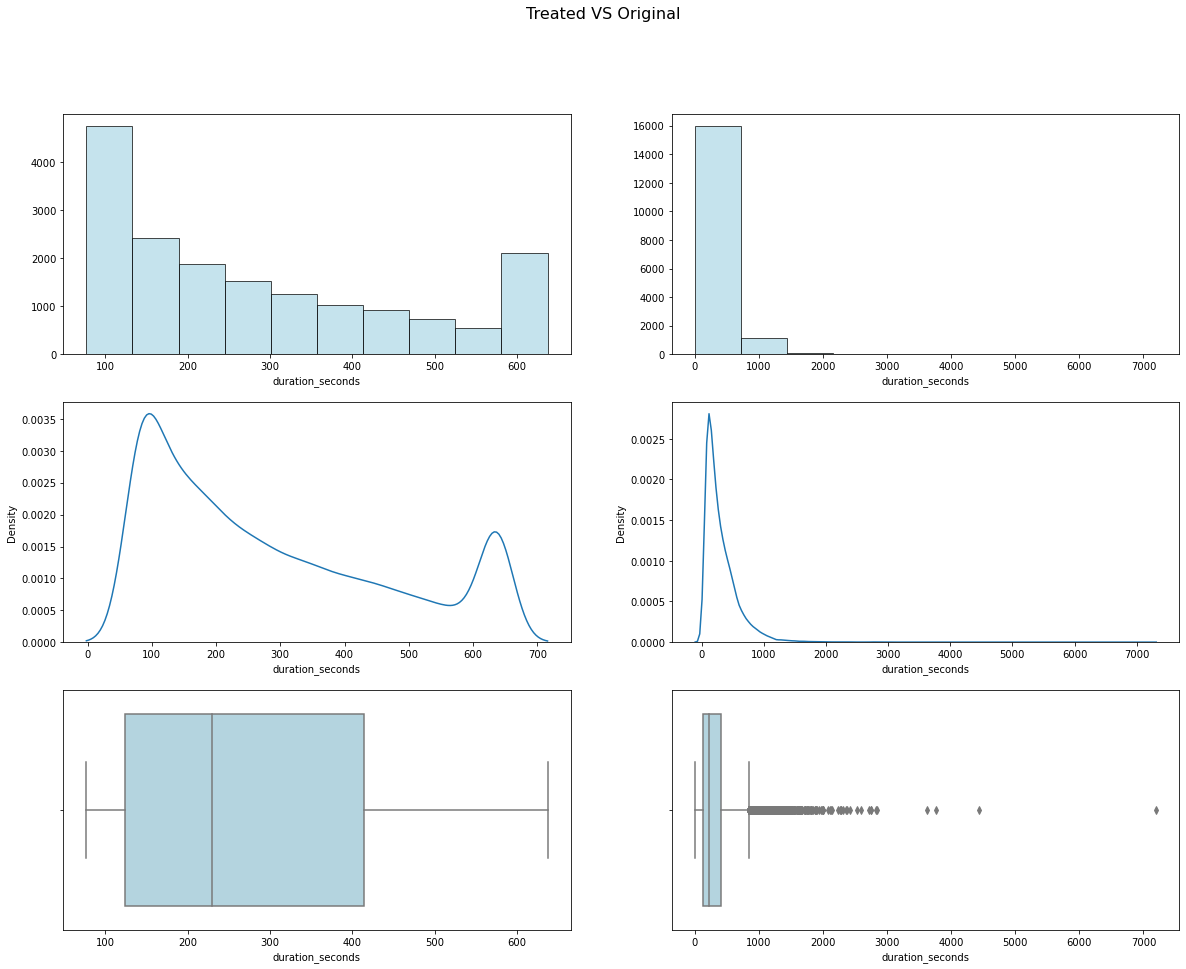

If we treat outliers with median

count   17197.00000
mean      283.41554
std       184.63025
min        77.00000
25%       124.00000
50%       229.00000
75%       414.00000
max       637.00000
Name: duration_seconds, dtype: float64

duration_seconds Skewness = 0.685





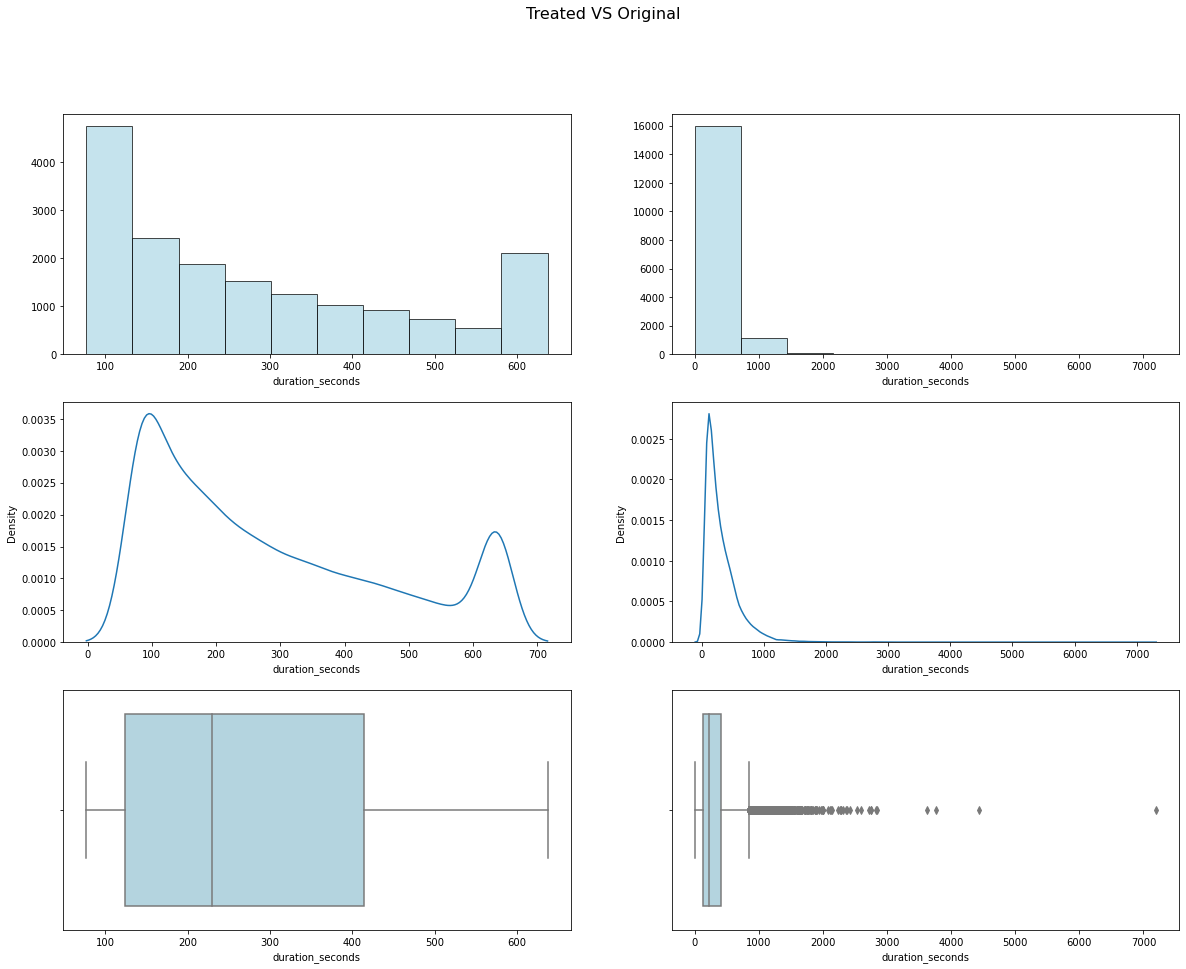

If we treat outliers with mean

count   17197.00000
mean      283.41554
std       184.63025
min        77.00000
25%       124.00000
50%       229.00000
75%       414.00000
max       637.00000
Name: duration_seconds, dtype: float64

duration_seconds Skewness = 0.685





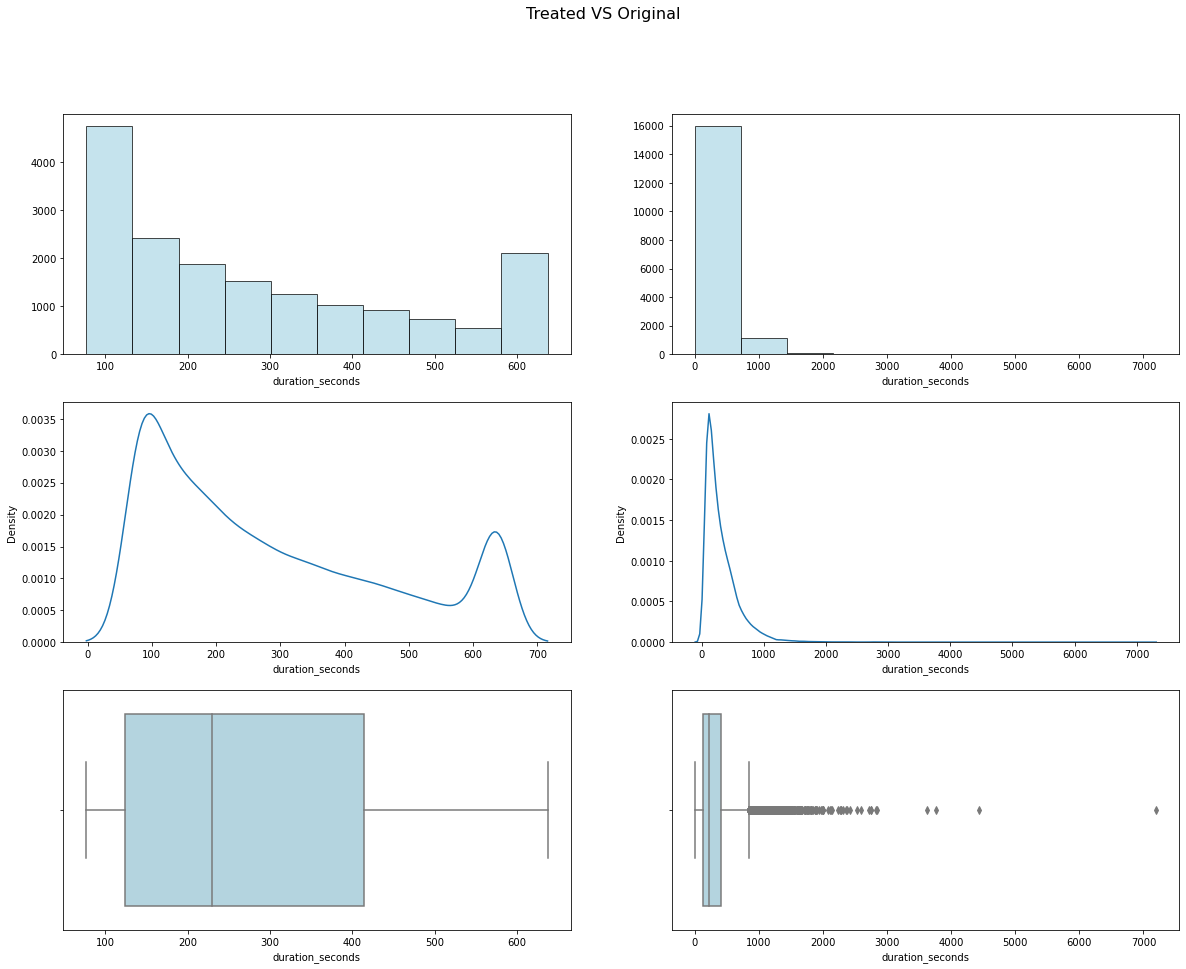

In [28]:
clN = 'duration_seconds'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
variableProfile(dat_tmp, colName=clN, varType='num')

Observation:
- Numerical variable
- Distribution in positively skewed
- Outliers are present

#### frn_review_classid_active

In [29]:
clN = 'frn_review_classid_active'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,frn_review_classid_active,Frequency,Percentage
0,True,16173,94.00000
1,False,1024,6.00000


,frn_review_classid_active,Frequency,Percentage
0,2,722,70.50000
1,1,289,28.20000
2,14,12,1.20000
3,0,1,0.10000


Observation:
- 94% of the data is missing. Practically unusable.

#### priority_status

In [30]:
clN = 'priority_status'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,priority_status,Frequency,Percentage
0,False,17197,100.00000


,priority_status,Frequency,Percentage
0,1,16092,93.60000
1,0,1105,6.40000


Observation:
- Binary variable
- Highly biased with 93% in a single category

#### entry_path

In [31]:
clN = 'entry_path'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,entry_path,Frequency,Percentage
0,False,17168,99.80000
1,True,29,0.20000


,entry_path,Frequency,Percentage
0,5,14622,85.20000
1,8,1949,11.40000
2,1,283,1.60000
3,6,154,0.90000
4,3,143,0.80000
5,0,17,0.10000


Observation:
- Categorical variable
- High bias with 85% values in a single category

#### frn_lskinid

In [32]:
clN = 'frn_lskinid'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,frn_lskinid,Frequency,Percentage
0,False,17197,100.00000


,frn_lskinid,Frequency,Percentage
0,36847,129,0.80000
1,15029,129,0.80000
2,138185,70,0.40000
3,60,61,0.40000
4,140637,54,0.30000
...,...,...,...
2857,143567,1,0.00000
2858,97323,1,0.00000
2859,94286,1,0.00000
2860,46213,1,0.00000


Observation:
- ID variable with very-high cardinality

#### cq_created

In [33]:
clN = 'cq_created'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN+'_year'] = dat_tmp[clN].dt.year
dat_tmp[clN+'_month'] = dat_tmp[clN].dt.month
dat_tmp[clN+'_day'] = dat_tmp[clN].dt.day
dat_tmp[clN+'_day_of_week'] = dat_tmp[clN].dt.day_of_week
dat_tmp[clN+'_hour'] = dat_tmp[clN].dt.hour
dat_tmp[clN+'_year_month'] = dat_tmp[clN+'_year'].astype(str)+' : '+dat_tmp[clN+'_month'].astype(str)

,cq_created,Frequency,Percentage
0,False,17197,100.00000


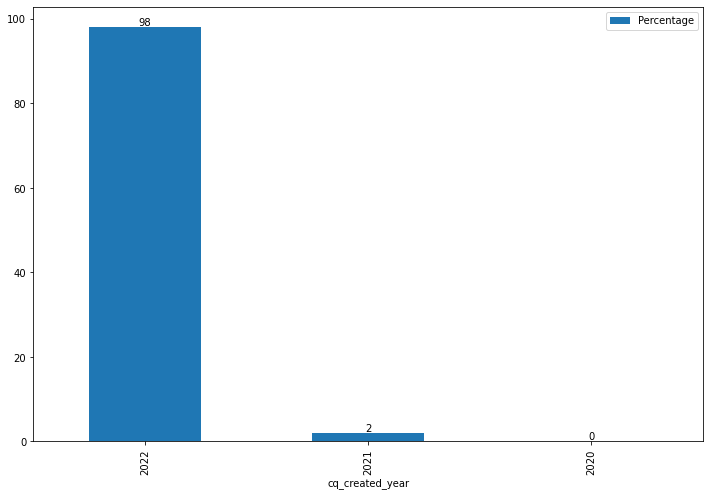

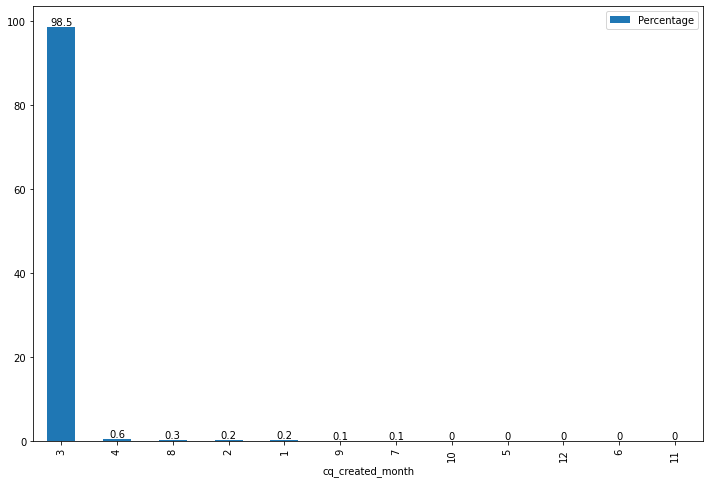

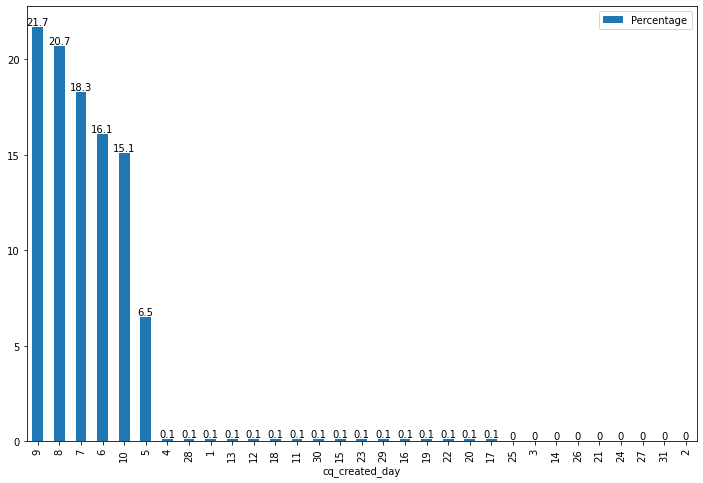

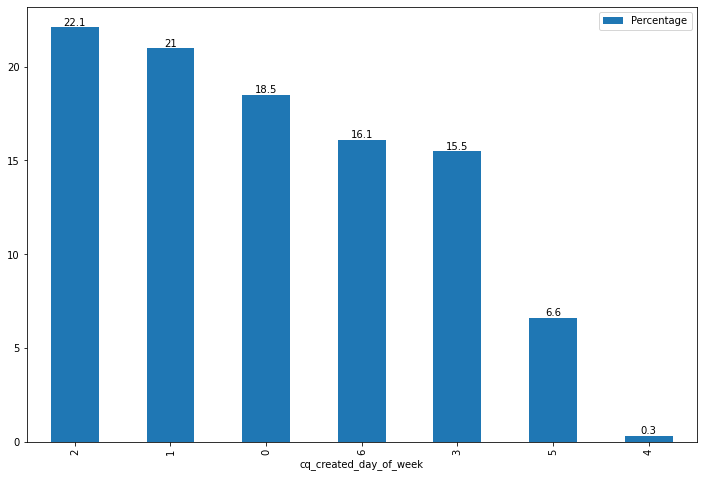

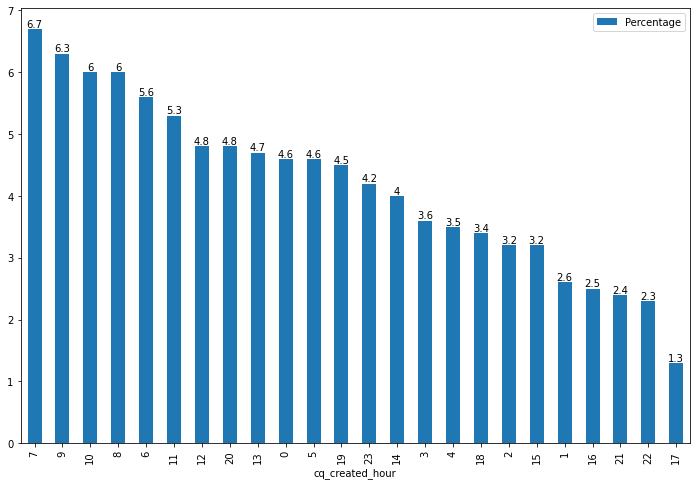

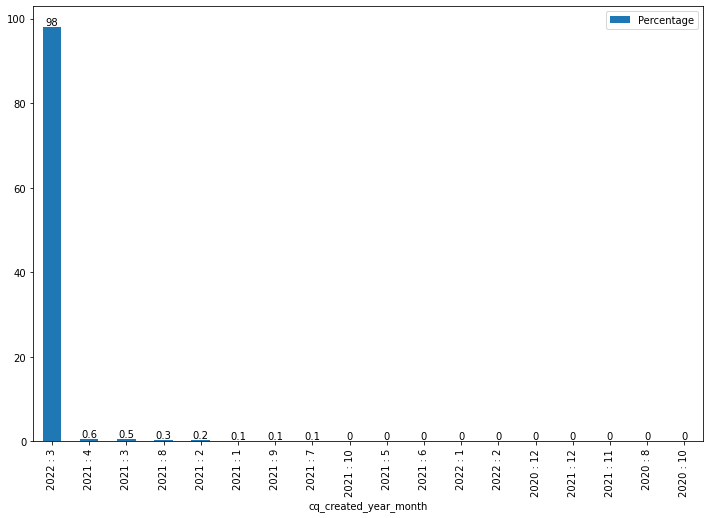

In [34]:
for cln in dat_tmp.columns:
    if clN+"_" in cln:
        ax = exph.distTab(dat_tmp, cln).plot.bar(x=cln,y='Percentage', figsize=(12, 8))
        ax.bar_label(ax.containers[0])

#### path_frn_hproductid

In [35]:
clN = 'path_frn_hproductid'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,path_frn_hproductid,Frequency,Percentage
0,False,17161,99.80000
1,True,36,0.20000


,path_frn_hproductid,Frequency,Percentage
0,12,8060,47.00000
1,2,4164,24.30000
2,3,3094,18.00000
3,1,1200,7.00000
4,4,619,3.60000
5,20,11,0.10000
6,14,10,0.10000
7,15,2,0.00000
8,9,1,0.00000


Observation:
- Categorical variable

#### time_in_queue

,time_in_queue,Frequency,Percentage
0,False,17160,99.80000
1,True,37,0.20000


count    17160.00000
mean      1020.94318
std       2624.99640
min          0.00000
25%        593.00000
50%        865.00000
75%       1339.00000
max     263423.00000
Name: time_in_queue, dtype: float64

time_in_queue Skewness = 75.79



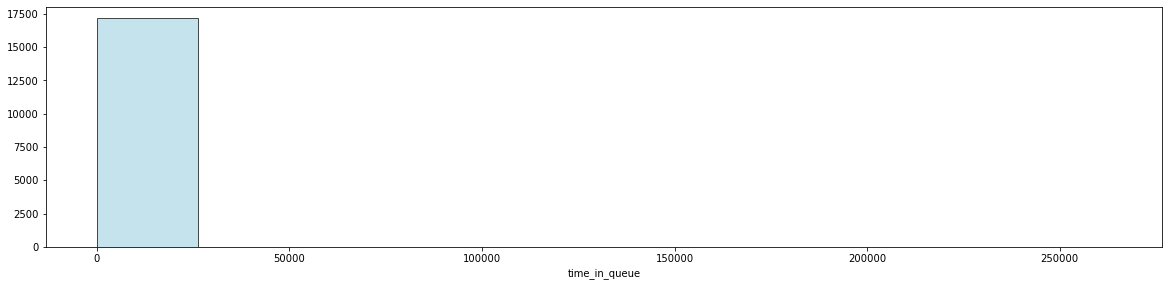

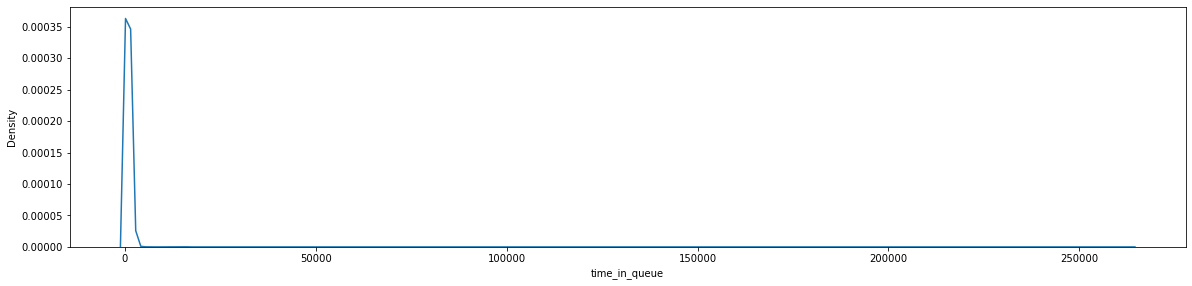

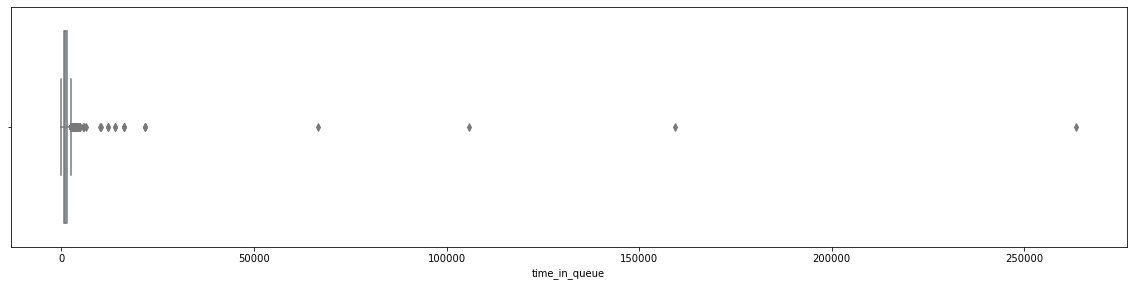

Outliers present in time_in_queue

time_in_queue IQR = 746.0

time_in_queue Lower outlier threshold = -526.0

time_in_queue Count of observations below lower outlier threshold = 0

time_in_queue Lower of observations below lower outlier threshold = 0.0

time_in_queue Upper outlier threshold = 2458.0

time_in_queue Count of observations over upper outlier threshold = 361

time_in_queue Upper of observations over upper outlier threshold = 2.1



If we treat outliers with Quantile-based Flooring and Capping

count   17160.00000
mean      952.47016
std       499.36266
min       233.00000
25%       593.00000
50%       865.00000
75%      1339.00000
max      1821.00000
Name: time_in_queue, dtype: float64

time_in_queue Skewness = 0.291





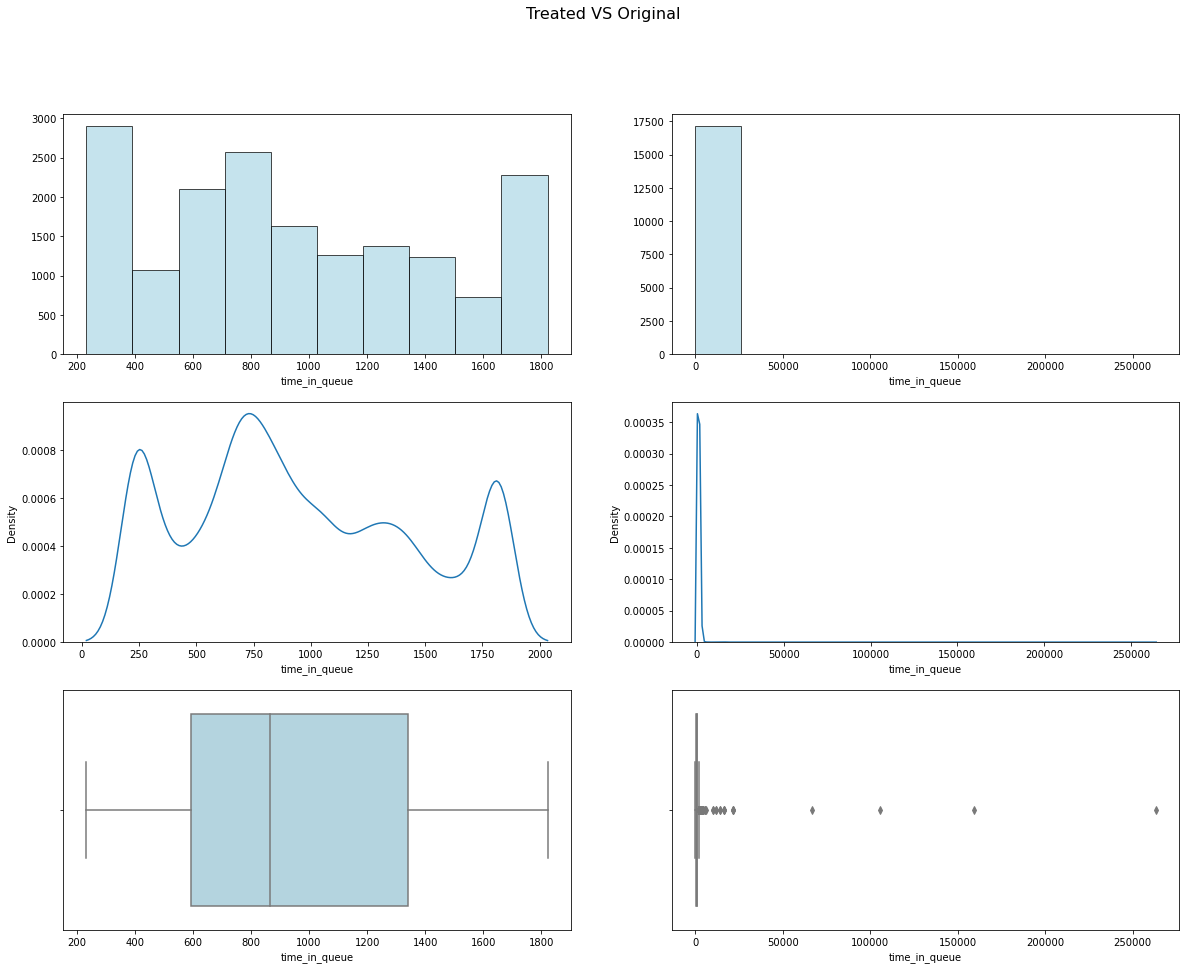

If we treat outliers with median

count   17160.00000
mean      952.47016
std       499.36266
min       233.00000
25%       593.00000
50%       865.00000
75%      1339.00000
max      1821.00000
Name: time_in_queue, dtype: float64

time_in_queue Skewness = 0.291





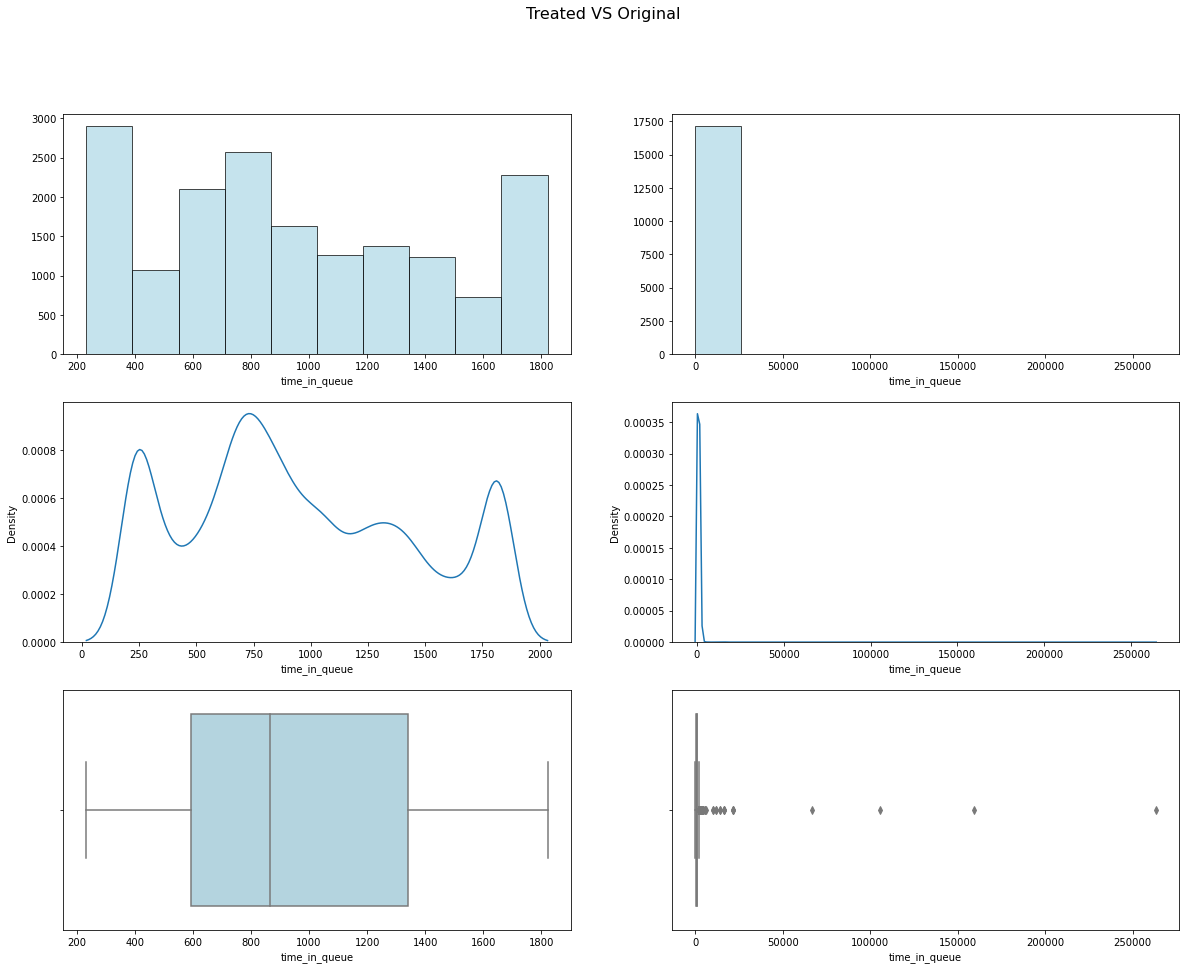

If we treat outliers with mean

count   17160.00000
mean      952.47016
std       499.36266
min       233.00000
25%       593.00000
50%       865.00000
75%      1339.00000
max      1821.00000
Name: time_in_queue, dtype: float64

time_in_queue Skewness = 0.291





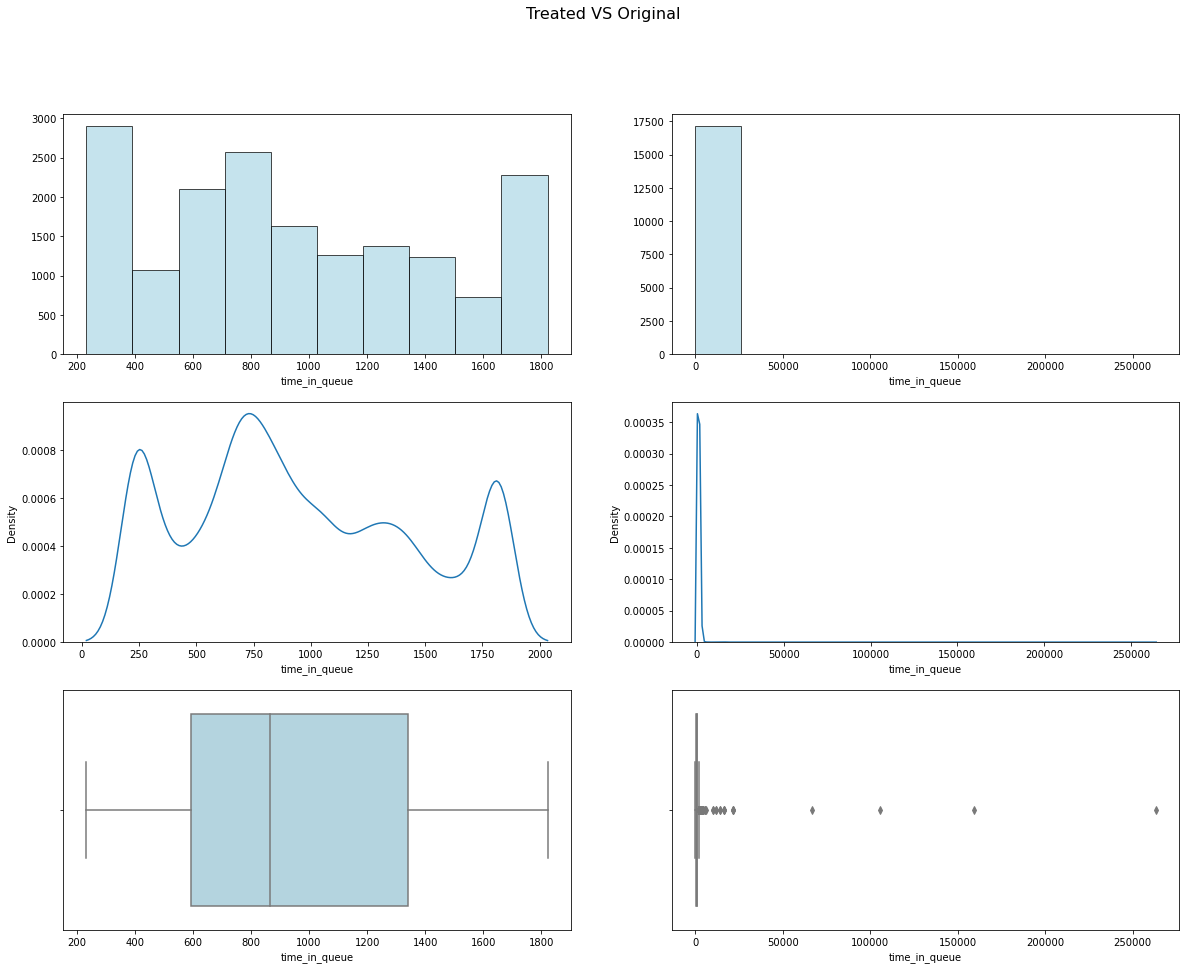

In [36]:
clN = 'time_in_queue'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
variableProfile(dat_tmp, colName=clN, varType='num')

#### ani

In [37]:
clN = 'ani'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,ani,Frequency,Percentage
0,True,14844,86.30000
1,False,2353,13.70000


,ani,Frequency,Percentage
0,-2147483648,2219,94.30000
1,2054409302,1,0.00000
2,2144756166,1,0.00000
3,2132927153,1,0.00000
4,2108056791,1,0.00000
...,...,...,...
130,2104870921,1,0.00000
131,2146627987,1,0.00000
132,2106067686,1,0.00000
133,2055275399,1,0.00000


Observation:
- 86% data is missing
- 94% data from the non-missing belogs to the same value
- Remaining ~96% of data is unique

#### website_call

In [38]:
clN = 'website_call'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN] = dat_tmp[clN].astype(int)
exph.distTab(dat_tmp, clN)

,website_call,Frequency,Percentage
0,False,17197,100.00000


,website_call,Frequency,Percentage
0,0,17043,99.10000
1,1,154,0.90000


Observation:
- Binary variable
- 99% data belongs to same class

#### tz_datetime

In [39]:
clN = 'tz_datetime'
display(exph.distTab(pd.isnull(dat[[clN]]), clN))
dat_tmp = dat[[clN]].dropna().copy()
dat_tmp[clN+'_year'] = dat_tmp[clN].dt.year
dat_tmp[clN+'_month'] = dat_tmp[clN].dt.month
dat_tmp[clN+'_day'] = dat_tmp[clN].dt.day
dat_tmp[clN+'_day_of_week'] = dat_tmp[clN].dt.day_of_week
dat_tmp[clN+'_hour'] = dat_tmp[clN].dt.hour
dat_tmp[clN+'_year_month'] = dat_tmp[clN+'_year'].astype(str)+' : '+dat_tmp[clN+'_month'].astype(str)

,tz_datetime,Frequency,Percentage
0,True,14835,86.30000
1,False,2362,13.70000


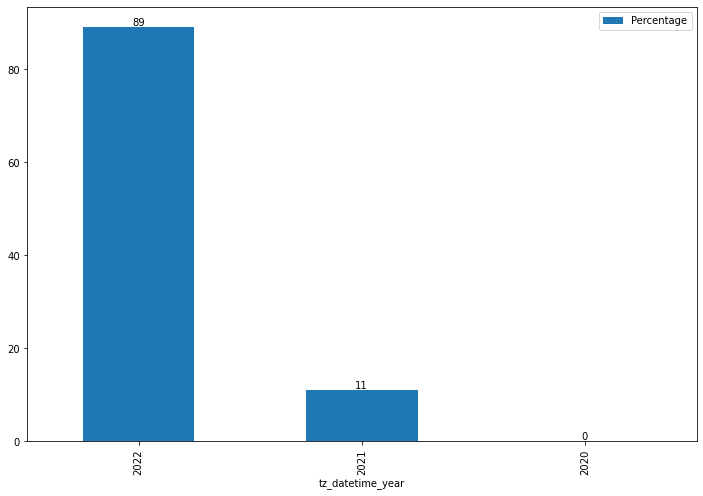

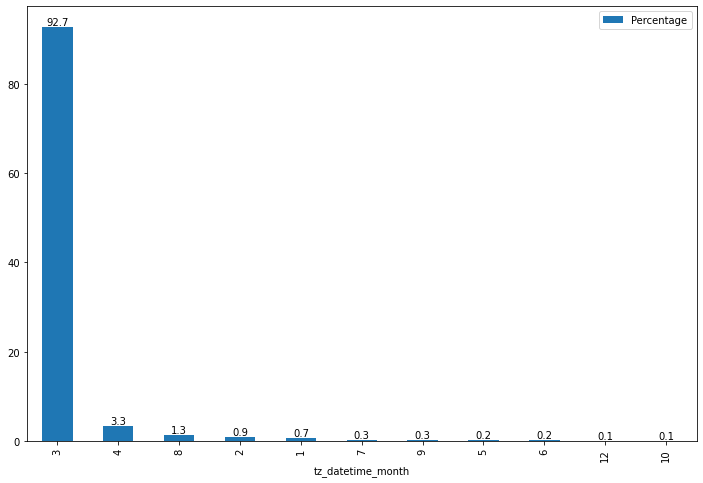

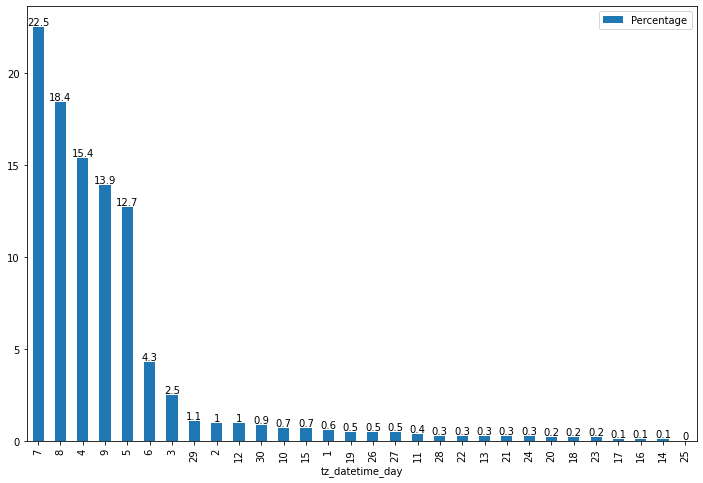

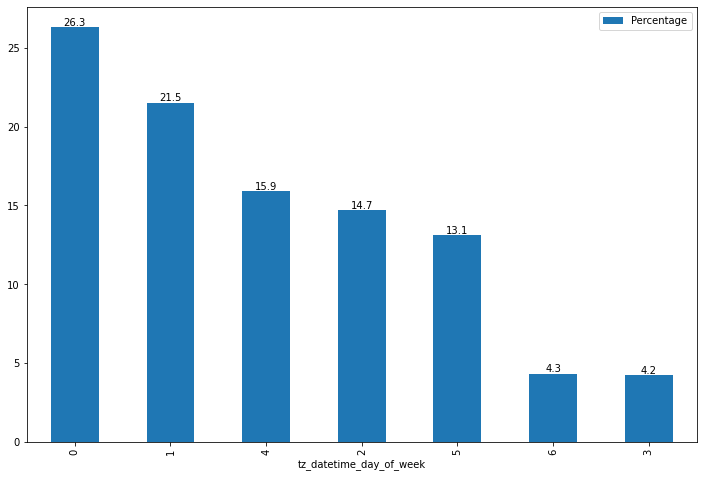

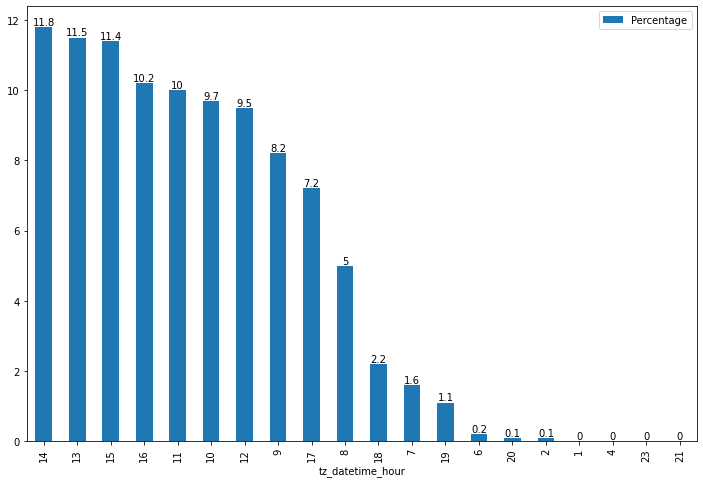

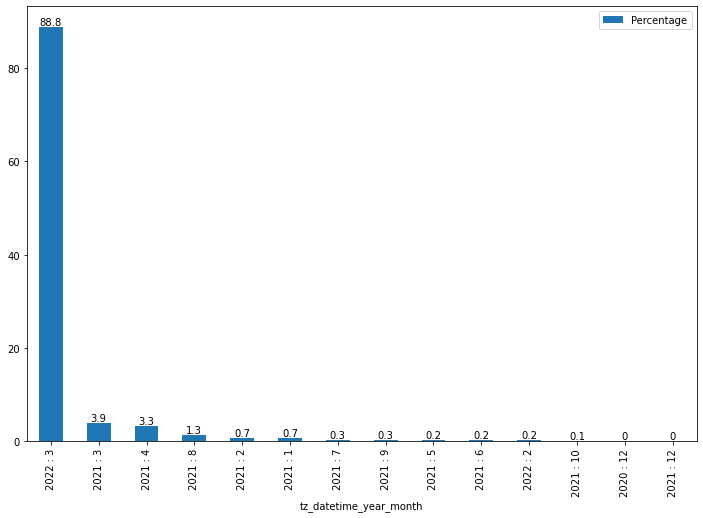

In [40]:
for cln in dat_tmp.columns:
    if clN+"_" in cln:
        ax = exph.distTab(dat_tmp, cln).plot.bar(x=cln,y='Percentage', figsize=(12, 8))
        ax.bar_label(ax.containers[0])

Observations
- 86% data is missing
- ~89% data is from March 2022
- There is sampling bias

#### Summary

Numerical variables:
- pickup 
- duration_seconds
- time_in_queue

ID variables:
- call_queueid
- frn_callid
- cf_frn_dnisid
- extension_frn_dnisid
- frn_phonecodeid
- frn_lskinid

Date-time variable:
- call_dt
- cq_created
- last_time_human_accessed
- tz_datetime

Binary variable:
- website_call
- priority_status

Categorical variable:
- path_frn_hproductid
- entry_path
- frn_review_classid_active


Target Variable:
- frn_hcat_optionid

In [41]:
# summary_profile = pd.read_clipboard()
# summary_profile

### Multivariate analysis

#### Filter

Variables to drop for initial analysis:
- call_queueid: ID variable with high cardinality
- frn_callid: ID variable with high cardinality
- call_dt: sampling bias
- cf_frn_dnisid: ID variable with high cardinality
- extension_frn_dnisid: ID variable with high cardinality, haldf of the data is missing
- dc_dialstring: High cardinality
- frn_phonecodeid: ID variable, 31% data is missing
- last_time_human_accessed: sampling bias
- frn_review_classid_active: 94% data is missing
- frn_lskinid: ID variable with high cardinality
- cq_created: sampling bias
- ani: 86% data is missing
- tz_datetime: 86% data is missing

In [42]:
usable_vars = ['frn_hcat_optionid','pickup',
               'duration_seconds',
               'priority_status',
               'entry_path',
               'path_frn_hproductid',
               'time_in_queue',
               'website_call']

In [43]:
dat_tmp = dat[usable_vars].copy()
dat_tmp

,frn_hcat_optionid,pickup,duration_seconds,priority_status,entry_path,path_frn_hproductid,time_in_queue,website_call
0,127601,0.00000,217,1,1.00000,12.00000,2.00000,0
1,987654,19.00000,386,1,5.00000,3.00000,120.00000,0
2,127599,NaN,77,1,6.00000,3.00000,3.00000,0
3,127605,NaN,169,1,6.00000,12.00000,0.00000,0
4,127601,18.00000,172,1,1.00000,12.00000,2.00000,0
...,...,...,...,...,...,...,...,...
17192,987654,0.00000,322,1,5.00000,2.00000,1092.00000,0
17193,987654,0.00000,36,1,5.00000,12.00000,571.00000,0
17194,127605,0.00000,194,1,8.00000,12.00000,79.00000,0
17195,987654,0.00000,116,1,8.00000,12.00000,20.00000,0


#### Missing

<AxesSubplot:>

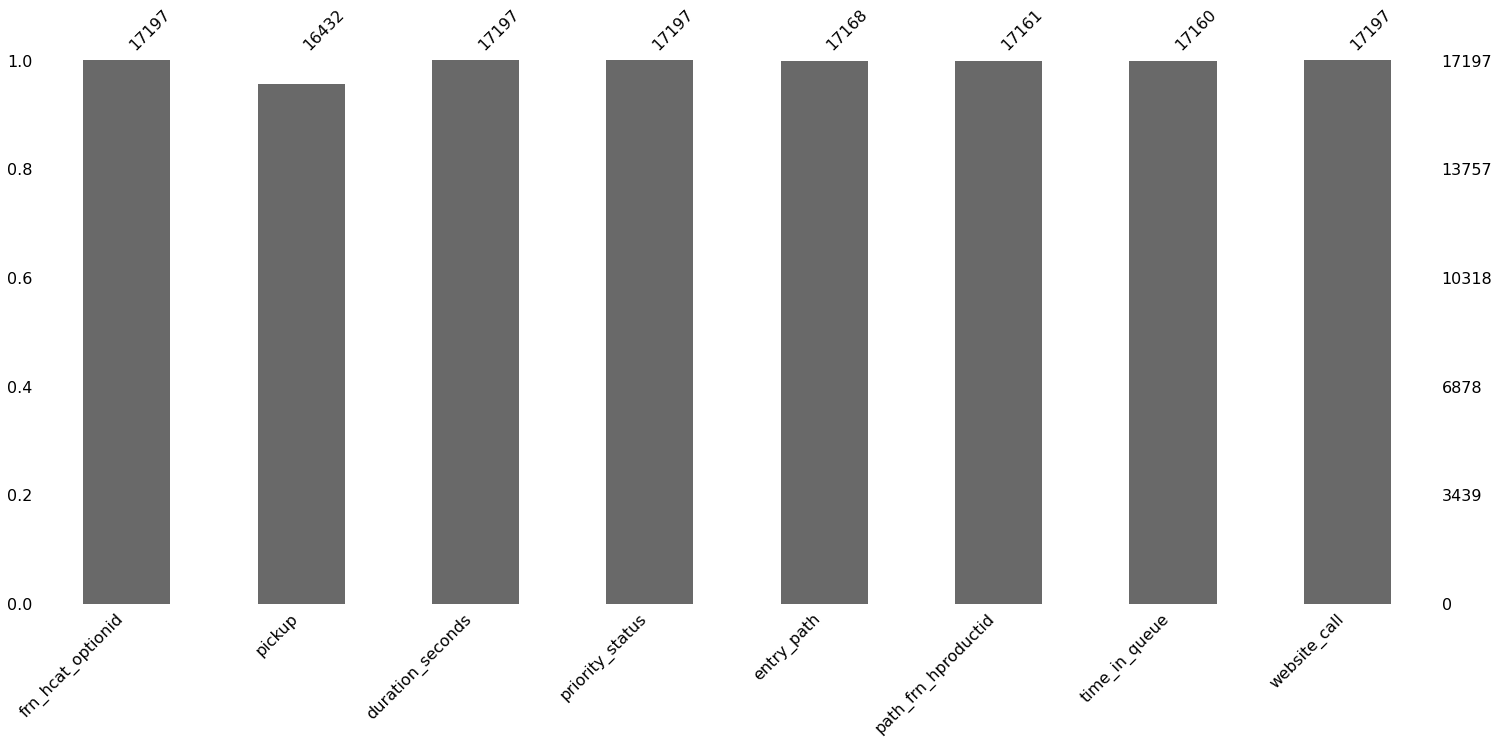

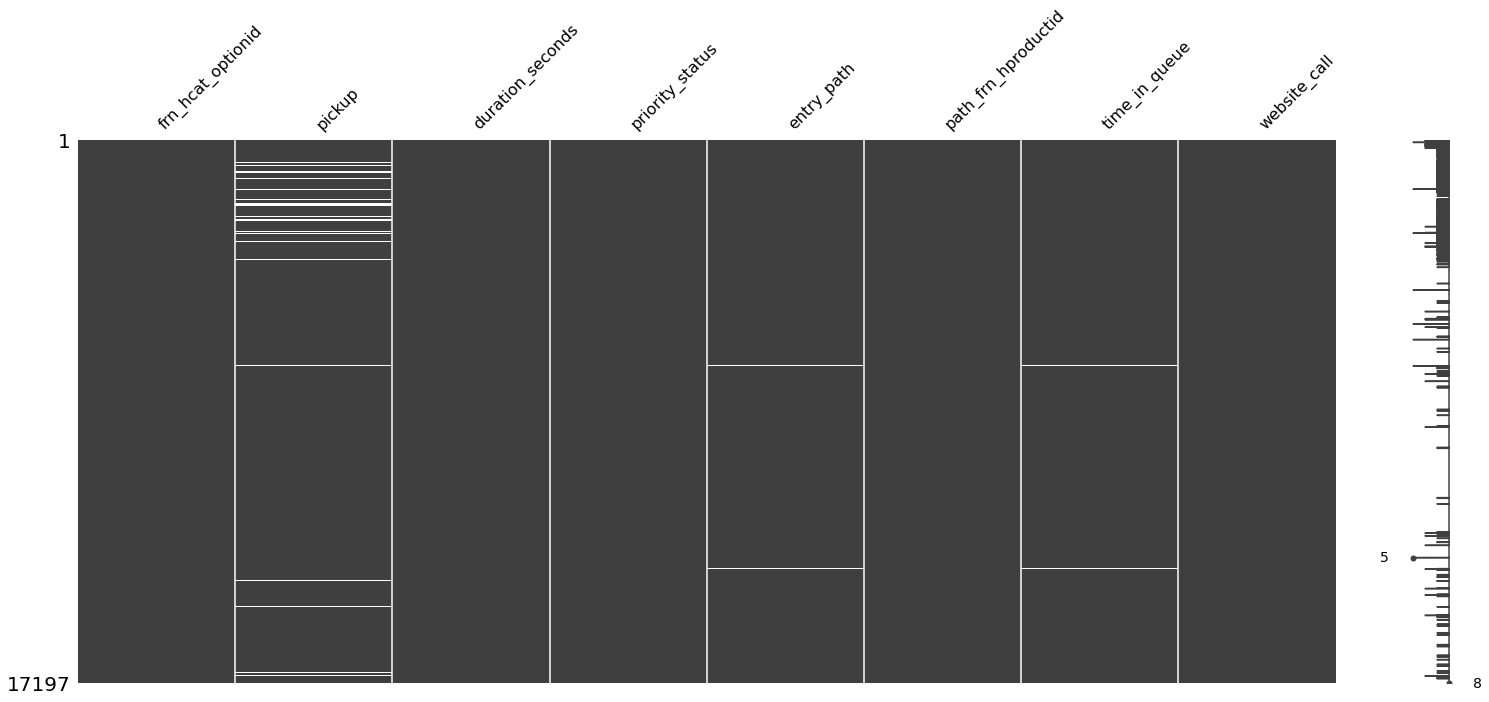

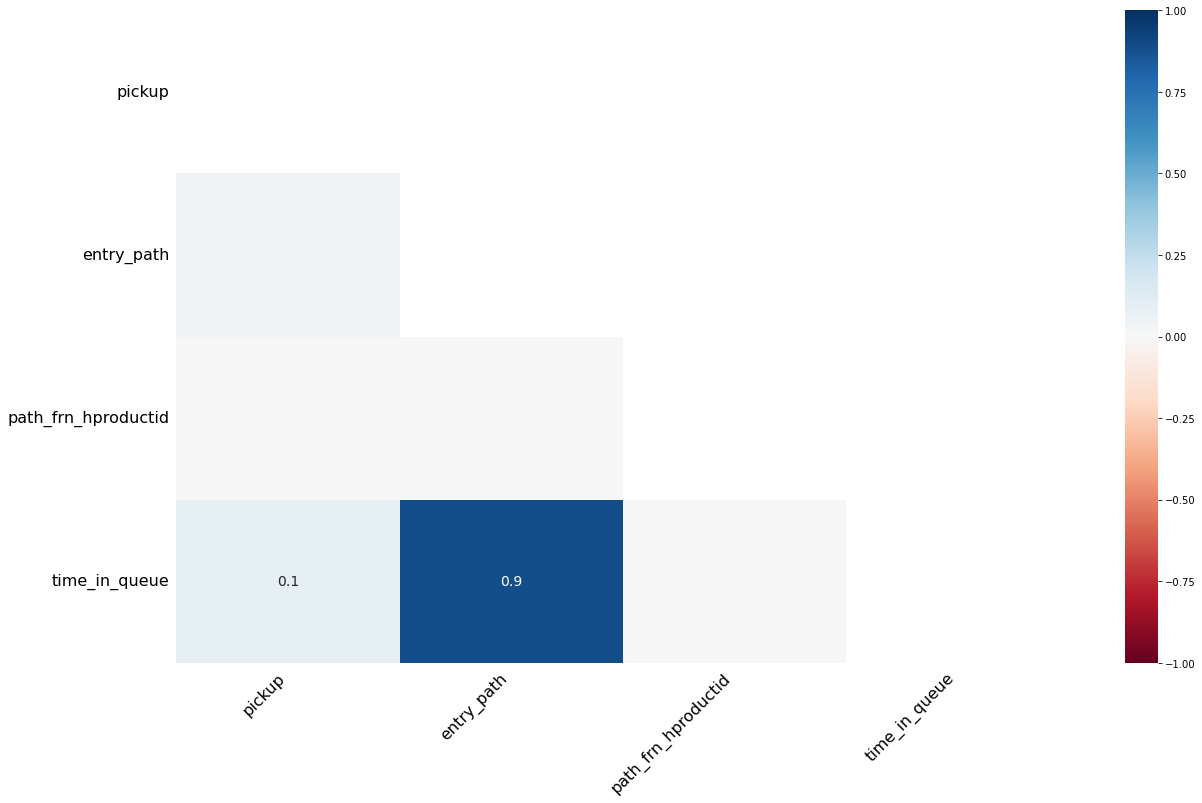

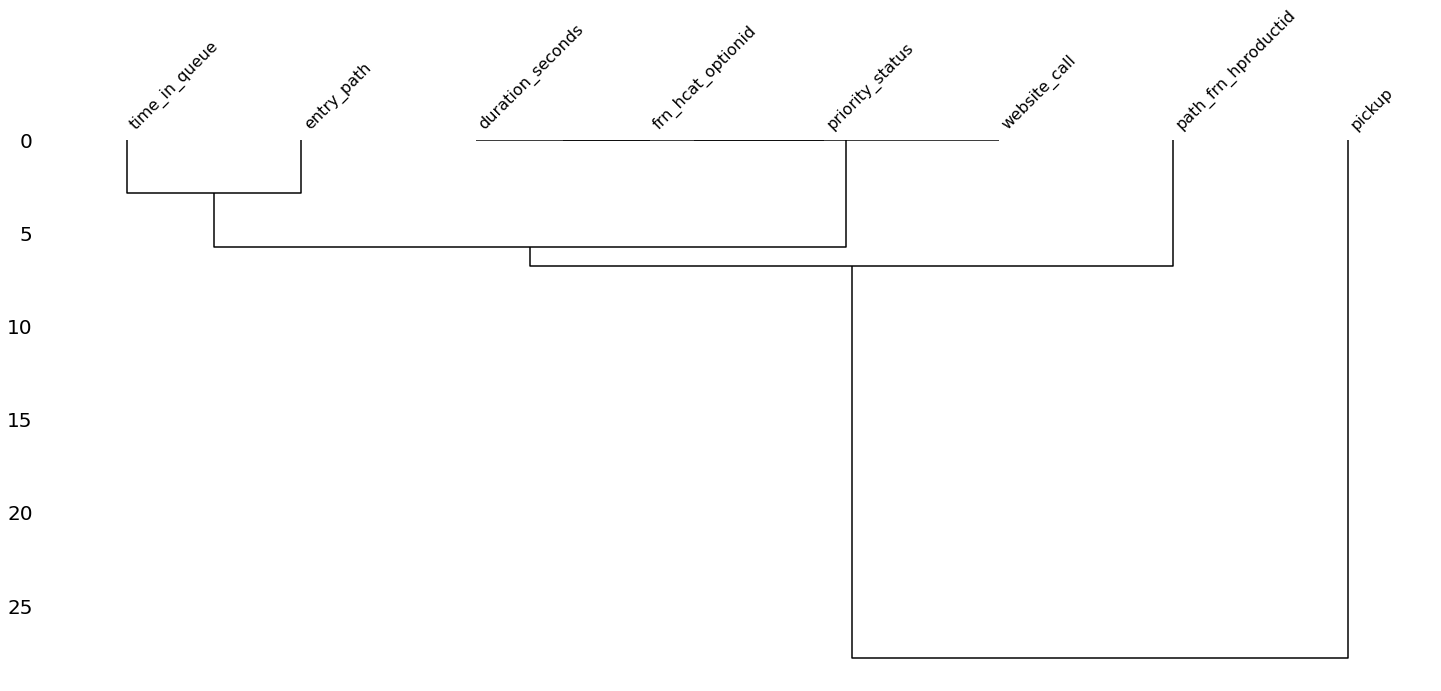

In [44]:
msno.bar(dat_tmp)
msno.matrix(dat_tmp)
msno.heatmap(dat_tmp)
msno.dendrogram(dat_tmp)

In [45]:
dat_tmp_miss = dat_tmp[~pd.notnull(dat_tmp['pickup'])]
dat_tmp_miss

,frn_hcat_optionid,pickup,duration_seconds,priority_status,entry_path,path_frn_hproductid,time_in_queue,website_call
2,127599,NaN,77,1,6.00000,3.00000,3.00000,0
3,127605,NaN,169,1,6.00000,12.00000,0.00000,0
5,127605,NaN,84,1,6.00000,3.00000,0.00000,0
11,127605,NaN,486,1,6.00000,1.00000,4.00000,0
12,987654,NaN,149,1,1.00000,2.00000,7.00000,0
...,...,...,...,...,...,...,...,...
17019,127600,NaN,233,1,6.00000,2.00000,3.00000,0
17038,987654,NaN,660,1,5.00000,12.00000,684.00000,0
17043,987654,NaN,589,1,5.00000,12.00000,829.00000,0
17045,987654,NaN,529,1,5.00000,12.00000,838.00000,0


,frn_hcat_optionid,Frequency,Percentage
0,987654,702,91.80000
1,127605,37,4.80000
2,127606,14,1.80000
3,127599,5,0.70000
4,127600,4,0.50000
5,127604,2,0.30000
6,127603,1,0.10000


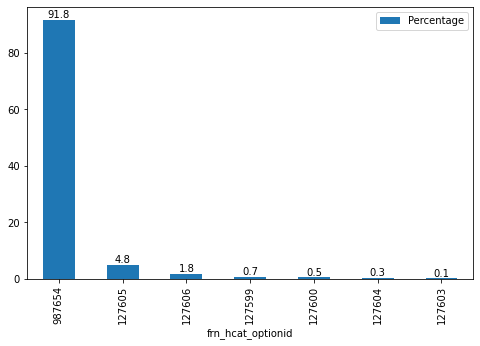

In [46]:
clN = 'frn_hcat_optionid'
ax = exph.distTab(dat_tmp_miss, clN).plot.bar(x=clN,y='Percentage', figsize=(8, 5))
ax.bar_label(ax.containers[0])
exph.distTab(dat_tmp_miss, clN)

,frn_hcat_optionid,Frequency,Percentage
0,987654,702,91.80000
1,127605,37,4.80000
2,127606,14,1.80000
3,127599,5,0.70000
4,127600,4,0.50000
5,127604,2,0.30000
6,127603,1,0.10000


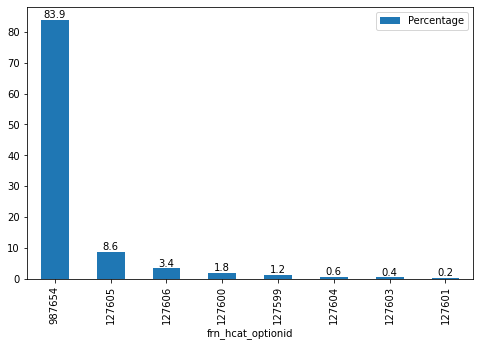

In [47]:
clN = 'frn_hcat_optionid'
ax = exph.distTab(dat, clN).plot.bar(x=clN,y='Percentage', figsize=(8, 5))
ax.bar_label(ax.containers[0])
exph.distTab(dat_tmp_miss, clN)

In [48]:
# Missing data
((dat_tmp.shape[0]-dat_tmp.dropna().shape[0])/dat_tmp.shape[0])*100

4.7740885038088035

In [49]:
dat_tmp = dat_tmp.dropna()
dat_tmp.reset_index(inplace=True, drop=True)
dat_tmp = dat_tmp.copy()

#### Data type

In [50]:
dat_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16376 entries, 0 to 16375
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frn_hcat_optionid    16376 non-null  object 
 1   pickup               16376 non-null  float64
 2   duration_seconds     16376 non-null  int64  
 3   priority_status      16376 non-null  int64  
 4   entry_path           16376 non-null  float64
 5   path_frn_hproductid  16376 non-null  float64
 6   time_in_queue        16376 non-null  float64
 7   website_call         16376 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1023.6+ KB


In [51]:
dat_tmp['frn_hcat_optionid'] = dat_tmp['frn_hcat_optionid'].astype('category')
dat_tmp['pickup'] = dat_tmp['pickup'].astype(int)
dat_tmp['duration_seconds'] = dat_tmp['duration_seconds'].astype(int)
dat_tmp['entry_path'] = dat_tmp['entry_path'].astype(int).astype('category')
dat_tmp['path_frn_hproductid'] = dat_tmp['path_frn_hproductid'].astype(int).astype('category')
dat_tmp['time_in_queue'] = dat_tmp['time_in_queue'].astype(int)

In [52]:
dat_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16376 entries, 0 to 16375
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   frn_hcat_optionid    16376 non-null  category
 1   pickup               16376 non-null  int32   
 2   duration_seconds     16376 non-null  int32   
 3   priority_status      16376 non-null  int64   
 4   entry_path           16376 non-null  category
 5   path_frn_hproductid  16376 non-null  category
 6   time_in_queue        16376 non-null  int32   
 7   website_call         16376 non-null  int64   
dtypes: category(3), int32(3), int64(2)
memory usage: 496.8 KB


#### Correlation

,pickup,duration_seconds,priority_status,time_in_queue,website_call,frn_hcat_optionid,entry_path,path_frn_hproductid
pickup,1.00000,0.07601,0.02031,0.01126,0.01359,0.05648,0.03403,0.13246
duration_seconds,0.07601,1.00000,0.11090,-0.03236,-0.04097,0.00000,0.00000,0.00000
priority_status,0.02031,0.11090,1.00000,-0.04146,-0.14807,0.52910,0.67193,0.12773
time_in_queue,0.01126,-0.03236,-0.04146,1.00000,0.01403,0.32097,0.40647,0.06137
website_call,0.01359,-0.04097,-0.14807,0.01403,1.00000,0.20790,0.24904,0.07113
frn_hcat_optionid,0.05648,0.00000,0.52910,0.32097,0.20790,1.00000,0.36875,0.06257
entry_path,0.03403,0.00000,0.67193,0.40647,0.24904,0.36875,1.00000,0.10635
path_frn_hproductid,0.13246,0.00000,0.12773,0.06137,0.07113,0.06257,0.10635,1.00000


C:\Users\DSC03\AppData\Local\Temp/ipykernel_29016/1604208918.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


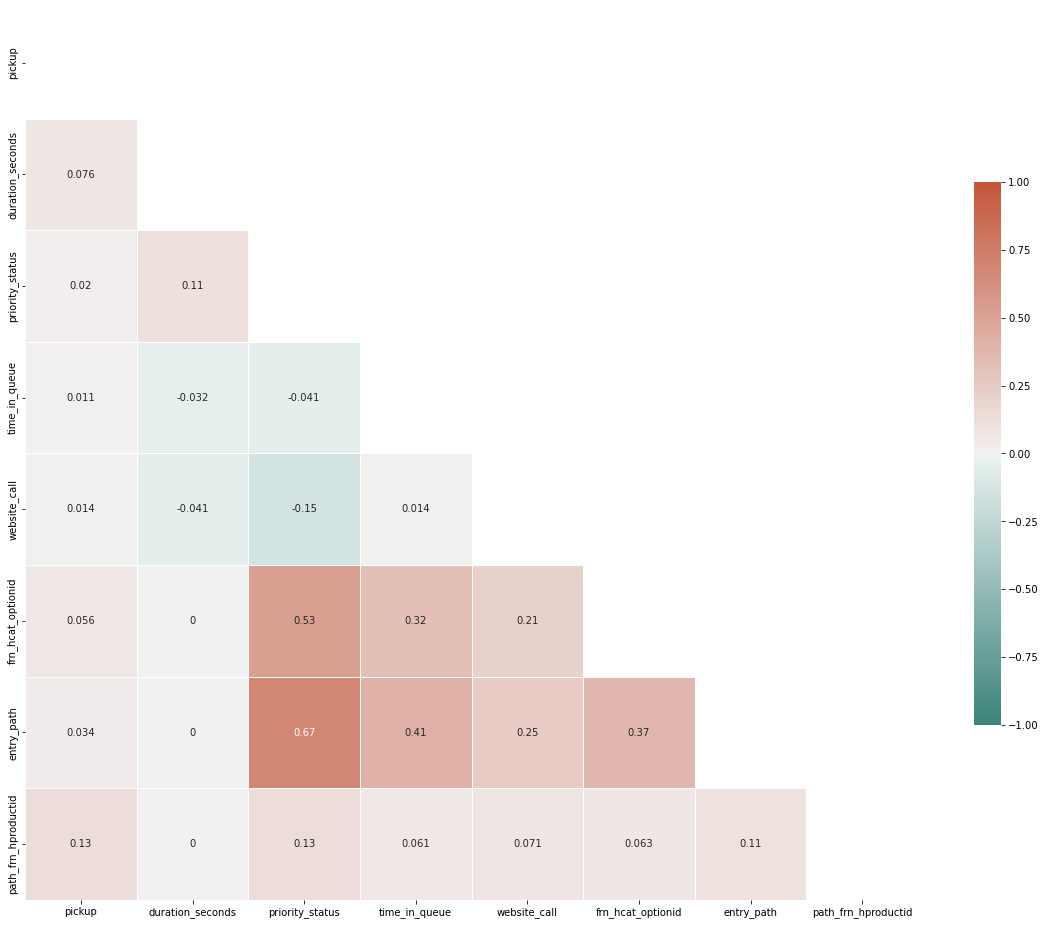

In [53]:
dat_tmp_correlation = corrCust(dat_tmp)
display(dat_tmp_correlation)
corrPlot(dat_tmp_correlation)

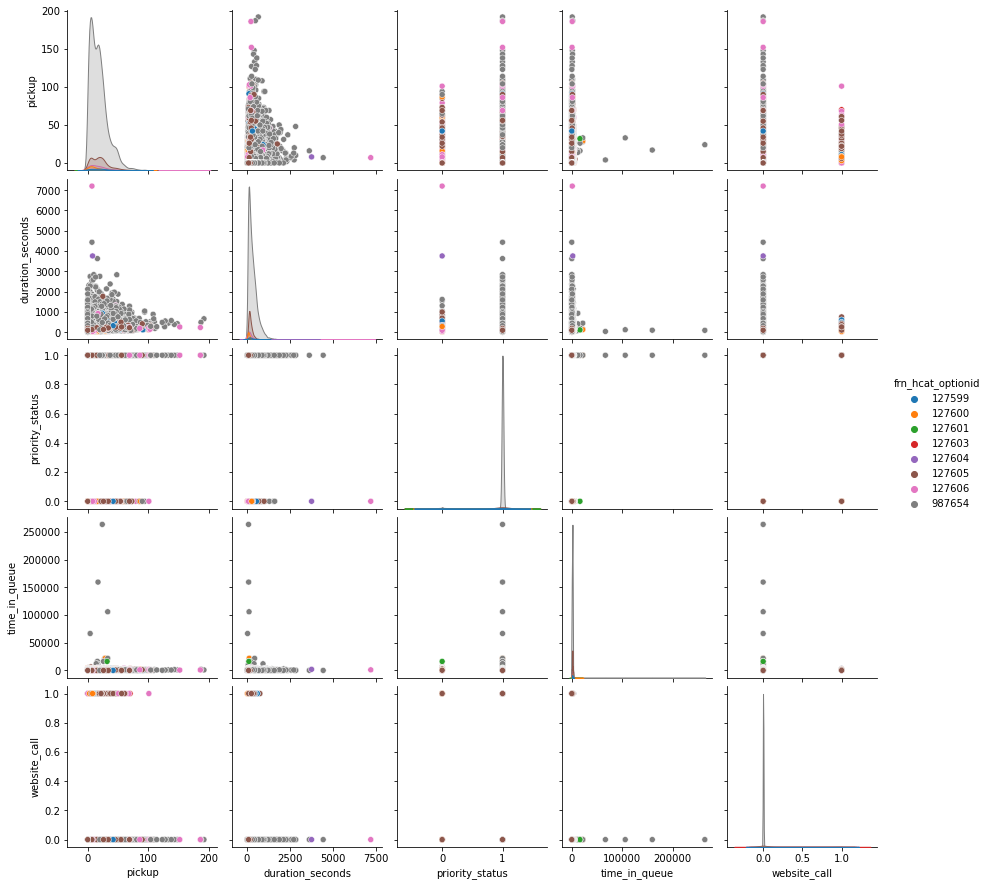

In [54]:
sns.pairplot(dat_tmp, hue ='frn_hcat_optionid')

In [55]:
df_dummies = pd.get_dummies(dat_tmp['frn_hcat_optionid'])
df_dummies.columns = ["frn_hcat_optionid_"+x for x in df_dummies.columns]
df_new = pd.concat([dat_tmp, df_dummies], axis=1)
display(df_new)
df_new.info()

,frn_hcat_optionid,pickup,duration_seconds,priority_status,entry_path,path_frn_hproductid,time_in_queue,website_call,frn_hcat_optionid_127599,frn_hcat_optionid_127600,frn_hcat_optionid_127601,frn_hcat_optionid_127603,frn_hcat_optionid_127604,frn_hcat_optionid_127605,frn_hcat_optionid_127606,frn_hcat_optionid_987654
0,127601,0,217,1,1,12,2,0,0,0,1,0,0,0,0,0
1,987654,19,386,1,5,3,120,0,0,0,0,0,0,0,0,1
2,127601,18,172,1,1,12,2,0,0,0,1,0,0,0,0,0
3,127605,15,276,1,3,3,4,0,0,0,0,0,0,1,0,0
4,127605,3,249,1,1,3,4,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16371,987654,0,322,1,5,2,1092,0,0,0,0,0,0,0,0,1
16372,987654,0,36,1,5,12,571,0,0,0,0,0,0,0,0,1
16373,127605,0,194,1,8,12,79,0,0,0,0,0,0,1,0,0
16374,987654,0,116,1,8,12,20,0,0,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16376 entries, 0 to 16375
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   frn_hcat_optionid         16376 non-null  category
 1   pickup                    16376 non-null  int32   
 2   duration_seconds          16376 non-null  int32   
 3   priority_status           16376 non-null  int64   
 4   entry_path                16376 non-null  category
 5   path_frn_hproductid       16376 non-null  category
 6   time_in_queue             16376 non-null  int32   
 7   website_call              16376 non-null  int64   
 8   frn_hcat_optionid_127599  16376 non-null  uint8   
 9   frn_hcat_optionid_127600  16376 non-null  uint8   
 10  frn_hcat_optionid_127601  16376 non-null  uint8   
 11  frn_hcat_optionid_127603  16376 non-null  uint8   
 12  frn_hcat_optionid_127604  16376 non-null  uint8   
 13  frn_hcat_optionid_127605  16376 non-null  uint

,pickup,duration_seconds,priority_status,time_in_queue,website_call,frn_hcat_optionid_127599,frn_hcat_optionid_127600,frn_hcat_optionid_127601,frn_hcat_optionid_127603,frn_hcat_optionid_127604,frn_hcat_optionid_127605,frn_hcat_optionid_127606,frn_hcat_optionid_987654,frn_hcat_optionid,entry_path,path_frn_hproductid
pickup,1.00000,0.07601,0.02031,0.01126,0.01359,0.01520,-0.04226,0.00712,-0.00010,0.01631,0.03714,0.01343,-0.02854,0.05648,0.03403,0.13246
duration_seconds,0.07601,1.00000,0.11090,-0.03236,-0.04097,-0.00888,-0.08630,-0.01227,-0.02624,-0.01489,-0.10658,-0.09491,0.17080,0.00000,0.00000,0.00000
priority_status,0.02031,0.11090,1.00000,-0.04146,-0.14807,-0.09037,-0.25182,-0.02043,-0.07884,-0.07255,-0.34265,-0.22117,0.51844,0.52910,0.67193,0.12773
time_in_queue,0.01126,-0.03236,-0.04146,1.00000,0.01403,0.01342,0.01249,0.00981,0.00871,0.01440,0.03366,0.01536,-0.04723,0.32097,0.40647,0.06137
website_call,0.01359,-0.04097,-0.14807,0.01403,1.00000,0.04229,0.03991,-0.00389,0.05274,0.01807,0.16209,0.08191,-0.20363,0.20790,0.24904,0.07113
frn_hcat_optionid_127599,0.01520,-0.00888,-0.09037,0.01342,0.04229,1.00000,-0.01457,-0.00434,-0.00703,-0.00819,-0.03378,-0.02063,-0.24678,0.99982,0.20796,0.05612
frn_hcat_optionid_127600,-0.04226,-0.08630,-0.25182,0.01249,0.03991,-0.01457,1.00000,-0.00534,-0.00864,-0.01006,-0.04150,-0.02534,-0.30314,0.99982,0.25826,0.09655
frn_hcat_optionid_127601,0.00712,-0.01227,-0.02043,0.00981,-0.00389,-0.00434,-0.00534,1.00000,-0.00258,-0.00300,-0.01237,-0.00755,-0.09035,0.99982,0.11234,0.00000
frn_hcat_optionid_127603,-0.00010,-0.02624,-0.07884,0.00871,0.05274,-0.00703,-0.00864,-0.00258,1.00000,-0.00485,-0.02003,-0.01223,-0.14630,0.99982,0.14575,0.02246
frn_hcat_optionid_127604,0.01631,-0.01489,-0.07255,0.01440,0.01807,-0.00819,-0.01006,-0.00300,-0.00485,1.00000,-0.02331,-0.01423,-0.17030,0.99982,0.16955,0.05403


C:\Users\DSC03\AppData\Local\Temp/ipykernel_29016/1604208918.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


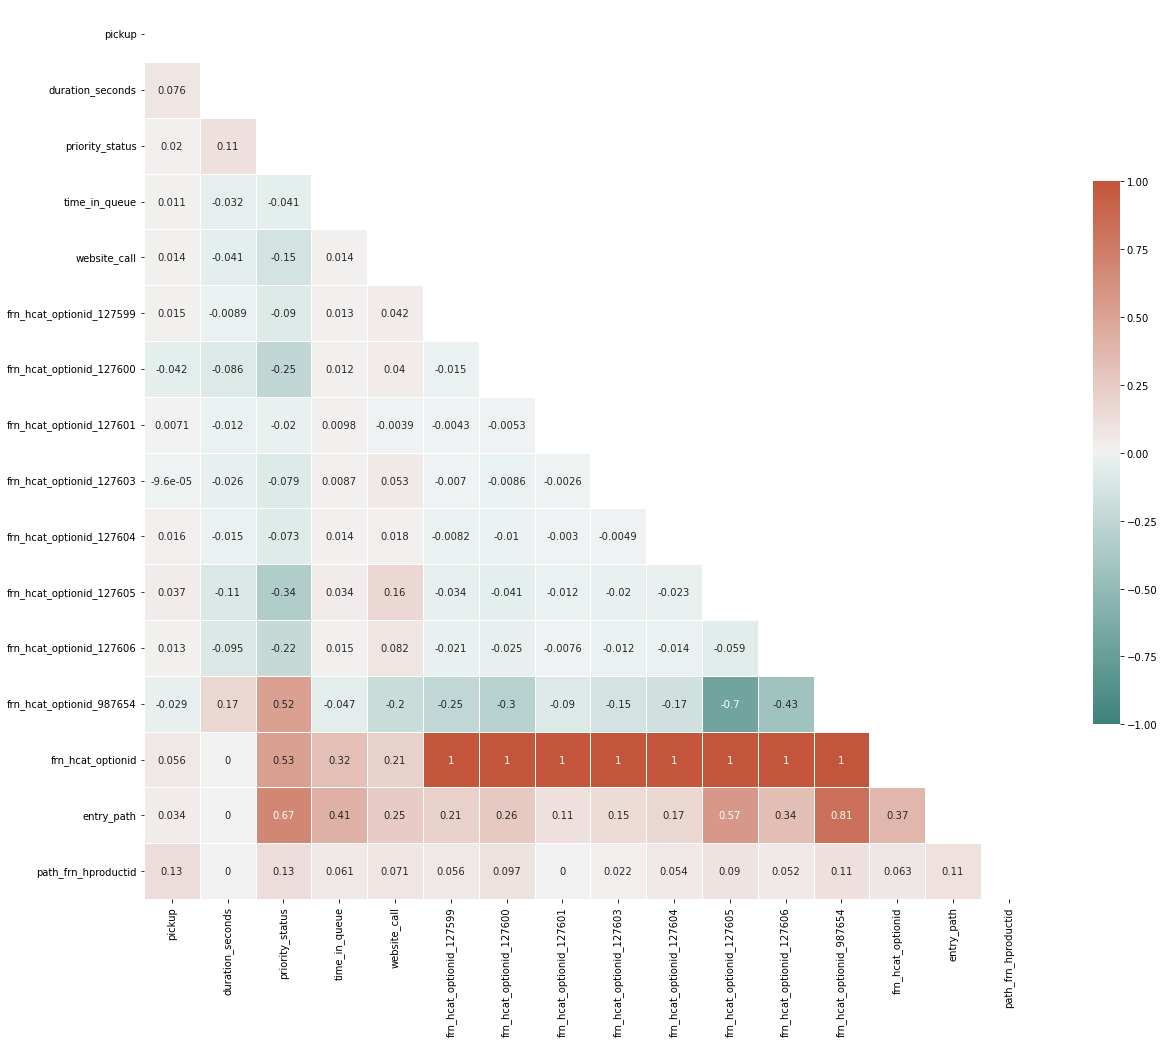

In [56]:
df_new_correlation = corrCust(df_new)
display(df_new_correlation)
corrPlot(df_new_correlation)

In [57]:
pd.crosstab(df_new['frn_hcat_optionid'],df_new['priority_status'])

priority_status,0,1
frn_hcat_optionid,,
127599,52,140
127600,153,135
127601,5,21
127603,25,43
127604,28,64
127605,487,950
127606,201,366
987654,122,13584


In [58]:
pd.crosstab(df_new['frn_hcat_optionid'],df_new['entry_path'])

entry_path,0,1,3,5,6,8
frn_hcat_optionid,,,,,,
127599,0,18,6,34,3,131
127600,0,9,8,55,6,210
127601,1,5,5,7,0,8
127603,0,0,1,9,0,58
127604,0,7,0,8,1,76
127605,0,110,51,298,22,956
127606,0,32,17,129,15,374
987654,14,75,54,13381,49,133


In [59]:
pd.crosstab(df_new['frn_hcat_optionid'],df_new['path_frn_hproductid'])

path_frn_hproductid,1,2,3,4,9,12,14,15,20
frn_hcat_optionid,,,,,,,,,
127599,16,14,25,0,0,136,1,0,0
127600,19,151,11,8,0,99,0,0,0
127601,2,3,7,0,0,14,0,0,0
127603,4,11,3,2,0,48,0,0,0
127604,18,3,6,0,0,65,0,0,0
127605,107,224,176,39,0,889,0,1,1
127606,66,144,51,13,0,293,0,0,0
987654,939,3170,2773,491,1,6313,8,1,10


## Audio

In [60]:
dat

,call_queueid,frn_callid,audio_file,call_dt,frn_hcat_optionid,cf_frn_dnisid,extension_frn_dnisid,dc_dialstring,pickup,frn_phonecodeid,last_time_human_accessed,duration_seconds,frn_review_classid_active,priority_status,entry_path,frn_lskinid,cq_created,path_frn_hproductid,time_in_queue,ani,website_call,tz_datetime
0,1784285815,6000070185177,https://s3.amazonaws.com/cic-audio/5105/202012...,2020-12-21 14:00:20+00:00,127601,34917289,NaN,7139413600.00000,0.00000,NaN,2020-12-22 13:01:27+00:00,217,1.00000,1,1.00000,116892,2020-12-22 13:01:27+00:00,12.00000,2.00000,3462412554.00000,0,2020-12-21 14:00:20+00:00
1,1789345059,6000073774587,https://s3.amazonaws.com/cic-audio/5108/202012...,2020-12-28 10:52:09+00:00,987654,3764241,35901302.00000,6784931059.00000,19.00000,NaN,2020-12-30 07:00:27+00:00,386,NaN,1,5.00000,72160,2020-12-30 07:00:27+00:00,3.00000,120.00000,NaN,0,NaT
2,1796464622,6000079355690,https://s3.amazonaws.com/cic-audio/5102/202101...,2021-01-05 10:14:00+00:00,127599,34912558,NaN,NaN,NaN,NaN,2021-01-08 18:01:22+00:00,77,NaN,1,6.00000,91840,2021-01-08 18:01:22+00:00,3.00000,3.00000,NaN,0,NaT
3,1797102296,6000080171268,https://s3.amazonaws.com/cic-audio/5107/202101...,2021-01-06 09:59:07+00:00,127605,34996631,35605735.00000,8474736071.00000,NaN,NaN,2021-01-09 15:27:43+00:00,169,NaN,1,6.00000,117997,2021-01-09 15:27:43+00:00,12.00000,0.00000,NaN,0,NaT
4,1797276202,6000083220618,https://s3.amazonaws.com/cic-audio/5107/202101...,2021-01-09 19:19:13+00:00,127601,3341077,3819732.00000,5035974632.00000,18.00000,NaN,2021-01-09 20:59:26+00:00,172,1.00000,1,1.00000,54913,2021-01-09 20:59:26+00:00,12.00000,2.00000,9712947766.00000,0,2021-01-09 17:19:13+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17192,2158084262,332203090014972,JiveAudio,2022-03-09 16:05:02+00:00,987654,36669210,36669204.00000,NaN,0.00000,4646307.00000,2022-03-10 14:32:59+00:00,322,NaN,1,5.00000,147342,2022-03-10 14:32:59+00:00,2.00000,1092.00000,NaN,0,NaT
17193,2157510146,332203090017117,JiveAudio,2022-03-09 17:43:59+00:00,987654,36625984,36625813.00000,NaN,0.00000,4361678.00000,2022-03-10 05:51:55+00:00,36,2.00000,1,5.00000,143821,2022-03-10 05:51:55+00:00,12.00000,571.00000,NaN,0,NaT
17194,2157442584,332203090017958,JiveAudio,2022-03-09 19:26:55+00:00,127605,36596081,36595632.00000,NaN,0.00000,3958970.00000,2022-03-09 21:07:49+00:00,194,1.00000,1,8.00000,55567,2022-03-09 21:07:49+00:00,12.00000,79.00000,6197770838.00000,0,2022-03-09 17:26:55+00:00
17195,2157454173,332203090018080,JiveAudio,2022-03-09 20:19:32+00:00,987654,36680840,36677702.00000,NaN,0.00000,4654658.00000,2022-03-09 21:36:46+00:00,116,1.00000,1,8.00000,688,2022-03-09 21:36:46+00:00,12.00000,20.00000,6023910288.00000,0,2022-03-09 19:19:32+00:00


In [63]:
dat['frn_hcat_optionid'].unique()

array(['127601', '987654', '127599', '127605', '127606', '127600',
       '127603', '127604'], dtype=object)

In [64]:
dat[dat['frn_hcat_optionid']=='127603']

,call_queueid,frn_callid,audio_file,call_dt,frn_hcat_optionid,cf_frn_dnisid,extension_frn_dnisid,dc_dialstring,pickup,frn_phonecodeid,last_time_human_accessed,duration_seconds,frn_review_classid_active,priority_status,entry_path,frn_lskinid,cq_created,path_frn_hproductid,time_in_queue,ani,website_call,tz_datetime
99,1852122976,6000129838466,https://s3.amazonaws.com/cic-audio/5108/202103...,2021-03-12 12:55:34+00:00,127603,3182052,NaN,5032914900.00000,7.00000,NaN,2021-03-13 12:11:14+00:00,117,NaN,1,3.00000,6090,2021-03-13 12:11:14+00:00,3.00000,11.00000,5038165069.00000,0,2021-03-12 10:55:34+00:00
138,1866285939,6000142540641,https://s3.amazonaws.com/cic-audio/5102/202103...,2021-03-29 12:09:29+00:00,127603,3523748,NaN,9034541930.00000,9.00000,NaN,NaT,238,NaN,0,NaN,36758,2021-03-31 02:25:13+00:00,12.00000,NaN,NaN,0,NaT
343,2153586822,6000392474899,https://s3.amazonaws.com/cic-audio/5009/202202...,2022-02-17 07:09:51+00:00,127603,2324861,NaN,6065492200.00000,1.00000,NaN,2022-03-06 09:20:45+00:00,337,NaN,1,5.00000,12502,2022-03-06 09:20:45+00:00,NaN,97.00000,NaN,0,NaT
513,2157440218,6000402309198,https://s3.amazonaws.com/cic-audio/5108/202203...,2022-03-01 13:49:00+00:00,127603,2324861,NaN,6065492200.00000,0.00000,NaN,2022-03-09 21:00:59+00:00,166,NaN,1,5.00000,12502,2022-03-09 21:00:59+00:00,NaN,40.00000,NaN,0,NaT
1695,2153510372,6000404248929,https://s3.amazonaws.com/cic-audio/5103/202203...,2022-03-03 15:37:24+00:00,127603,3133087,4173305.00000,4085534598.00000,70.00000,4421452.00000,2022-03-05 20:16:55+00:00,134,NaN,1,8.00000,36846,2022-03-05 20:16:55+00:00,12.00000,3100.00000,9163073775.00000,1,2022-03-03 13:37:24+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16488,2157758969,6000408840267,https://s3.amazonaws.com/cic-audio/5107/202203...,2022-03-09 14:41:06+00:00,127603,36664904,NaN,7652881903.00000,0.00000,NaN,2022-03-10 11:09:29+00:00,250,NaN,0,8.00000,40397,2022-03-10 11:09:29+00:00,12.00000,1211.00000,7652124563.00000,0,2022-03-09 15:41:06+00:00
16515,2157787664,6000408851945,https://s3.amazonaws.com/cic-audio/5108/202203...,2022-03-09 14:50:11+00:00,127603,3970128,4021960.00000,3034646634.00000,30.00000,NaN,2022-03-10 11:28:09+00:00,171,NaN,0,8.00000,44639,2022-03-10 11:28:09+00:00,12.00000,1128.00000,3038096006.00000,0,2022-03-09 13:50:11+00:00
16540,2157802392,6000408859979,https://s3.amazonaws.com/cic-audio/5103/202203...,2022-03-09 14:54:08+00:00,127603,3708,4358527.00000,2144726833.00000,32.00000,4567249.00000,2022-03-10 11:37:19+00:00,218,NaN,1,8.00000,13,2022-03-10 11:37:19+00:00,1.00000,1228.00000,4406977162.00000,0,2022-03-09 14:54:08+00:00
16949,2158102389,6000408975401,https://s3.amazonaws.com/cic-audio/5108/202203...,2022-03-09 16:16:42+00:00,127603,34924398,34930888.00000,7025588063.00000,32.00000,NaN,2022-03-10 14:44:28+00:00,181,NaN,1,8.00000,52830,2022-03-10 14:44:28+00:00,12.00000,1331.00000,8013811719.00000,0,2022-03-09 14:16:42+00:00


In [65]:
!python --version

Python 3.9.7


In [1]:
!python --version

Python 3.9.7
